In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from Functions.FunctionsDataVisualization import plotConfusionMatrix, savefig, snsConfusionMatrix, distOutputLayer
from lps_toolbox.metrics.classification import sp_index
from sklearn.metrics import recall_score,confusion_matrix

import pickle

from sklearn.preprocessing import LabelEncoder

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import md5, sha

path_classif = os.environ['CLASSIFICATION_RESULTS']
path_figures_classif = os.environ['CLASSIFICATION_FIGURES']

df_bd_all = pd.read_csv(path_classif+'/bd.csv')
database='24classes'

qtd_class = int(database[:2])

Using TensorFlow backend.


In [2]:
print(path_figures_classif)
df_bd_all.head()

/home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures


,PCD,analysis_name,batch_size,callbacks,database,dev,hash,hidden_activation,learning_rate,loss,...,n_folds,n_inits,n_neurons,observation,optmizerAlgorithm,output_activation,path,type_arq,version,weight
0,False,Classification,32,NaN,24classes,0,5bfc737449ee6456cac4cab9f98fe170ecc557e4e43c95...,tanh,NaN,mean_squared_error,...,10,10,10,NaN,adam,tanh,/home/venancio/Workspace/SonarAnalysis/Results...,Hierarquica,NaN,1
1,False,Classification,512,NaN,24classes,0,320bfda004a9386b284d95a8cf59f215df9a469377d060...,tanh,NaN,mean_squared_error,...,10,3,30,NaN,adam,tanh,/home/venancio/Workspace/SonarAnalysis/Results...,Hierarquica,NaN,1
2,False,Classification,32,NaN,24classes,1,b25c24ef3f5d7149688a176b37363718c76f2f7c583119...,tanh,NaN,mean_squared_error,...,10,10,10,NaN,adam,tanh,/home/venancio/Workspace/SonarAnalysis/Results...,MLP,NaN,1
3,False,Classification,512,NaN,24classes,0,ffa8a89bea9ffca89975d49398b045b028ce084cab9f1a...,tanh,NaN,mean_squared_error,...,10,3,10,NaN,adam,tanh,/home/venancio/Workspace/SonarAnalysis/Results...,Hierarquica,NaN,1
4,False,Classification,512,NaN,24classes,0,ad53bfe756e7dde5146a2272a6b4d6887515ec6fb5bcaa...,tanh,NaN,mean_squared_error,...,10,10,10,NaN,adam,tanh,/home/venancio/Workspace/SonarAnalysis/Results...,MLP,NaN,1


In [3]:
if database=='31classes':
    classes={'class_S':[[1,2,3,4],
                        [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]],

            'class_A':[[1],
                       [2],
                       [3],
                       [4]],

            'class_B':[[5],
                       [6],
                       [7,8,9,10,11],
                       [12],
                       [13,14,15],
                       [16],
                       [17],
                       [18,19,20,21,22,23,24,25,26,27,28,29,30,31]],
             
            'class_B3':[[7],
                        [8],
                        [9],
                        [10],
                        [11]],

            'class_B5':[[13],
                        [14],
                        [15]],
            
            'class_B8':[[18],
                        [19],
                        [20],
                        [21],
                        [22],
                        [23],
                        [24],
                        [25],
                        [26],
                        [27],
                        [28],
                        [29],
                        [30],
                        [31]],}

    map_lvl = {
        'class_S':0,
        'class_A':1,
        'class_B':1,
        'class_B3':2,
        'class_B5':2,
        'class_B8':2
    }

else:
    classes={'class_S':[[9,10,13,14,16,23,1,2,22,21],
                                 [4,6,8,12,17,19],
                                 [11,24],
                                 [5,7,15,3,18,20]],
            'class_A':[[9,10,13,14,16],
                            [23,1,2,22],
                            [21]],
            'class_B':[[4],
                            [6],
                            [8],
                            [12],
                            [17],
                            [19]],
            'class_D':[[5,7,15],
                    [3,18,20]],
             
            'class_C':[[11],
                        [24]],
            'class_AA':[[9],
                             [10],
                             [13],
                             [14],
                             [16]],
            'class_AB':[[23],
                             [1],
                             [2],
                             [22]],
            'class_DA':[[5],
                             [7],
                             [15]],
            'class_DB':[[3],
                             [18],
                             [20]]}

class_name = list(classes.keys())

In [29]:
#Não utilize essa forma






#analise de apenas uma rede em especifico


n_folds = 10
folds = 10
neurons = 25

start_neu = 5
finish_neu = 300
p = 5
range_neurons =[5,10,15,20,25,30,35,40,45,50,100,150,250,300]#range(start_neu,finish_neu,p)

if database=='31classes':
    batch = 64
else:
    batch = 512
        
init = 3

files = {}
files_fold = {}
eff_ech_class = {}
# file_hier = path_classif + '/Hierarq_{0}_{1}_inits_{2}_folds_{3}_neurons_adam_optmizer_True_balanced_mapstd_norm_1000_epochs_{4}_batch_size_tanh_hidden_activation_tanh_output_activation_acc_sp_metric_mean_squared_error_loss'.format(
#                 database,init,folds,neurons,batch)


df_bd = df_bd_all.query('database==\'24classes\' & n_neurons==30 & type_arq==\'Hierarquica\'')
path_result = df_bd.path.values[0]


file_hier = path_result
tese_goltz = path_figures_classif + '/{0}'.format(df_bd.hash.values[0])
# neurons_hierarqNet = []
# for ineuron in range_neurons:
#     path = path_classif + '/Hierarq_{0}_{1}_inits_{2}_folds_{3}_neurons_adam_optmizer_True_balanced_mapstd_norm_1000_epochs_{4}_batch_size_tanh_hidden_activation_tanh_output_activation_acc_sp_metric_mean_squared_error_loss'.format(
#                 database,init,folds,ineuron,batch)
    
#     neurons_hierarqNet.append(path)


# path_figures = path_figures_classif + '/Hierarq_{}_{}_start_{}_finish_{}pat_neurons_{}_init_{}_fold_{}_batch'.format(database,start_neu,finish_neu,p,init,folds,batch)
# tese_goltz = path_figures_classif +  '/Hierarq_{0}_{1}_inits_{2}_folds_{3}_neurons_adam_optmizer_True_balanced_mapstd_norm_1000_epochs_{4}_batch_size_tanh_hidden_activation_tanh_output_activation_acc_sp_metric_mean_squared_error_loss'.format(
#                 database,init,folds,neurons,batch)

# if not os.path.exists(path_figures):
#     os.mkdir(path_figures)
    
if not os.path.exists(tese_goltz):
    os.mkdir(tese_goltz)

In [4]:
#analise de apenas uma rede em especifico
# Cuidado, apenas usar isso em caso de já ter escolhido o n_neuronios e tem ciencia de qual o melhor
if database=='31classes':
    query_analyse = 'database==\'31classes\' & n_inits==10 & PCD==False & type_arq==\'Hierarquica\' & batch_size==64 & observation!=\'Super with all classes\'  & n_neurons==30'
if database=='24classes':
    query_analyse = 'database==\'24classes\' & n_inits==10 & PCD==False & type_arq==\'Hierarquica\' & batch_size==512 & n_neurons==50 & observation!=\'Super with all classes\''
        
files = {}
files_fold = {}
eff_ech_class = {}
# file_hier = path_classif + '/Hierarq_{0}_{1}_inits_{2}_folds_{3}_neurons_adam_optmizer_True_balanced_mapstd_norm_1000_epochs_{4}_batch_size_tanh_hidden_activation_tanh_output_activation_acc_sp_metric_mean_squared_error_loss'.format(
#                 database,init,folds,neurons,batch)

n_folds=10
df_bd_all = pd.read_csv(path_classif+'/bd.csv')
df_bd = df_bd_all.query(query_analyse)
print df_bd.drop(['hash','path'],axis=1)
path_result = df_bd.path.values[0]


file_hier = path_result
tese_goltz = path_figures_classif + '/{0}'.format(df_bd.hash.values[0])
# neurons_hierarqNet = []
# for ineuron in range_neurons:
#     path = path_classif + '/Hierarq_{0}_{1}_inits_{2}_folds_{3}_neurons_adam_optmizer_True_balanced_mapstd_norm_1000_epochs_{4}_batch_size_tanh_hidden_activation_tanh_output_activation_acc_sp_metric_mean_squared_error_loss'.format(
#                 database,init,folds,ineuron,batch)
    
#     neurons_hierarqNet.append(path)



# tese_goltz = path_figures_classif +  '/Hierarq_{0}_{1}_inits_{2}_folds_{3}_neurons_adam_optmizer_True_balanced_mapstd_norm_1000_epochs_{4}_batch_size_tanh_hidden_activation_tanh_output_activation_acc_sp_metric_mean_squared_error_loss'.format(
#                 database,init,folds,neurons,batch)

    
if not os.path.exists(tese_goltz):
    os.mkdir(tese_goltz)

      PCD   analysis_name  batch_size callbacks   database  dev  \
34  False  Classification         512       NaN  24classes    0   

   hidden_activation  learning_rate                loss metrics  n_epochs  \
34              tanh            NaN  mean_squared_error  acc,sp      1000   

    n_folds  n_inits  n_neurons observation optmizerAlgorithm  \
34       10       10         50         NaN              adam   

   output_activation     type_arq version  weight  
34              tanh  Hierarquica     NaN       1  


In [4]:
# for analysis of all neurons

if database=='31classes':
    query = 'database==\'31classes\' & n_inits==10 & PCD==False & type_arq==\'Hierarquica\' & batch_size==64 & observation!=\'Super with all classes\' '
    batch=64
if database=='24classes':
    query = 'database==\'24classes\' & n_inits==10 & PCD==False & type_arq==\'Hierarquica\' & batch_size==512 & observation!=\'Super with all classes\''
    batch=512
    
init = 10
folds = 10
n_folds = 10   

neurons_hierarqNet = {}

df_bd = df_bd_all.query(query)
for row in df_bd[['n_neurons','path']].itertuples():
    neurons_hierarqNet[row.n_neurons] = row.path
    
print list(sorted(neurons_hierarqNet.iteritems()))
path_figures = path_figures_classif + '/Hierarq_%s_%s_neurons_%i_init_%i_fold_%s_batch'%(database,'_'.join(map(str,neurons_hierarqNet.keys())),init,folds,batch)

if not os.path.exists(path_figures):
    os.mkdir(path_figures)

[(5, '/home/venancio/Workspace/SonarAnalysis/Results/Classification/26ee8114b8bf98c789bd302fe5a44adf293445c601ef38d4bba63ed74b1c662f'), (10, '/home/venancio/Workspace/SonarAnalysis/Results/Classification/49bb9a86401b8d43f3109f2c1094111d73649adc389a6b93e134fe8e1557db67'), (20, '/home/venancio/Workspace/SonarAnalysis/Results/Classification/81e8a3756fc5059779e276d603b46c3efb13edfa3c7303ef3d94e5fdbe275dfa'), (30, '/home/venancio/Workspace/SonarAnalysis/Results/Classification/6832d4052d8c8c77702687a70ad73acb5586fc5bd16425d3390ca7427d9935f1'), (50, '/home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a'), (100, '/home/venancio/Workspace/SonarAnalysis/Results/Classification/03745decd12e1584d2eed3e5ea7d2aac1c5101f0e363d57d89f82b55891748a0'), (200, '/home/venancio/Workspace/SonarAnalysis/Results/Classification/2657b501fbb07bd324d4757b99ca2b42b942f246ca78fc8a56473eeeb1a17339')]


In [5]:
df_bd

,PCD,analysis_name,batch_size,database,dev,hash,hidden_activation,loss,metrics,n_epochs,n_folds,n_inits,n_neurons,observation,optmizerAlgorithm,output_activation,path,type_arq,version,weight
19,False,Classification,512,24classes,False,26ee8114b8bf98c789bd302fe5a44adf293445c601ef38...,tanh,mean_squared_error,"acc,sp",1000,10,10,5,NaN,adam,tanh,/home/venancio/Workspace/SonarAnalysis/Results...,Hierarquica,NaN,True
20,False,Classification,512,24classes,False,49bb9a86401b8d43f3109f2c1094111d73649adc389a6b...,tanh,mean_squared_error,"acc,sp",1000,10,10,10,NaN,adam,tanh,/home/venancio/Workspace/SonarAnalysis/Results...,Hierarquica,NaN,True
21,False,Classification,512,24classes,False,81e8a3756fc5059779e276d603b46c3efb13edfa3c7303...,tanh,mean_squared_error,"acc,sp",1000,10,10,20,NaN,adam,tanh,/home/venancio/Workspace/SonarAnalysis/Results...,Hierarquica,NaN,True
22,False,Classification,512,24classes,False,6832d4052d8c8c77702687a70ad73acb5586fc5bd16425...,tanh,mean_squared_error,"acc,sp",1000,10,10,30,NaN,adam,tanh,/home/venancio/Workspace/SonarAnalysis/Results...,Hierarquica,NaN,True
34,False,Classification,512,24classes,False,927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d...,tanh,mean_squared_error,"acc,sp",1000,10,10,50,NaN,adam,tanh,/home/venancio/Workspace/SonarAnalysis/Results...,Hierarquica,NaN,True
42,False,Classification,512,24classes,False,03745decd12e1584d2eed3e5ea7d2aac1c5101f0e363d5...,tanh,mean_squared_error,"acc,sp",1000,10,10,100,NaN,adam,tanh,/home/venancio/Workspace/SonarAnalysis/Results...,Hierarquica,NaN,True
46,False,Classification,512,24classes,False,2657b501fbb07bd324d4757b99ca2b42b942f246ca78fc...,tanh,mean_squared_error,"acc,sp",1000,10,10,200,NaN,adam,tanh,/home/venancio/Workspace/SonarAnalysis/Results...,Hierarquica,NaN,True


# Analise variando Neuronios

In [6]:
flag_tmp = True
file_actu = path_figures+'/sp_all.csv'

if not os.path.exists(file_actu):
    sp_all = []
    for iclass in class_name:
        for ineuron,path in sorted(neurons_hierarqNet.iteritems()):
            for ifold in range(n_folds):
                df_pred = pd.read_csv(path + '/fold0{0}'.format(ifold) + '/pred_all.csv')
                pred = df_pred[iclass].values
                table_master = pd.read_csv(path+'/fold0{0}'.format(ifold)+'/master_table.csv')
                test_id = table_master[(table_master[iclass]!=-1)&(table_master['fold_0{0}'.format(ifold)]==1)].index.values
                true = table_master[iclass].values

                sp = sp_index(y_pred=pred[test_id],y_true=true[test_id])
                sp_all.append(sp)

        print "finished {}".format(iclass)
else:
    class_tmp = ['class_Super' if x=='class_S' else x for x in class_name]
    idxs = pd.MultiIndex.from_product(iterables=[["{0}".format(i.split('_')[-1]) for i in class_tmp],range_neurons,range(1,11)],names=['Membro',u'Neurônios','folds'])
    dft=pd.read_csv(file_actu,index_col=range(len(idxs.names)))#, index_col=0)
    dft.index = idxs
    flag_tmp = False

finished class_B
finished class_S
finished class_A
finished class_AA
finished class_D
finished class_C
finished class_DB
finished class_DA
finished class_AB


In [8]:
save=True

if flag_tmp:
    class_tmp = ['class_Super' if x=='class_S' else x for x in class_name]
    idxs = pd.MultiIndex.from_product(iterables=[["{0}".format(i.split('_')[-1]) for i in class_tmp],sorted(neurons_hierarqNet.keys()),range(1,11)],names=['Membro',u'Neuronios','folds'])
    dft = pd.DataFrame({'SP':sp_all},index=idxs)

if (save)&(not os.path.exists(path_figures+'/sp_all.csv')):
    dft.to_csv(path_figures+'/sp_all.csv')

dft.head()

SP
Membro Neuronios folds          
B      5         1      0.962130
                 2      0.962196
                 3      0.951072
                 4      0.960930
                 5      0.964156

  Membro  Neuronios  folds        SP
0      B          5      1  0.962130
1      B          5      2  0.962196
2      B          5      3  0.951072
3      B          5      4  0.960930
4      B          5      5  0.964156
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/Hierarq_24classes_100_5_200_10_50_20_30_neurons_10_init_10_fold_512_batch/SPXneuronXmember.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/SPXneuronXmember.png file


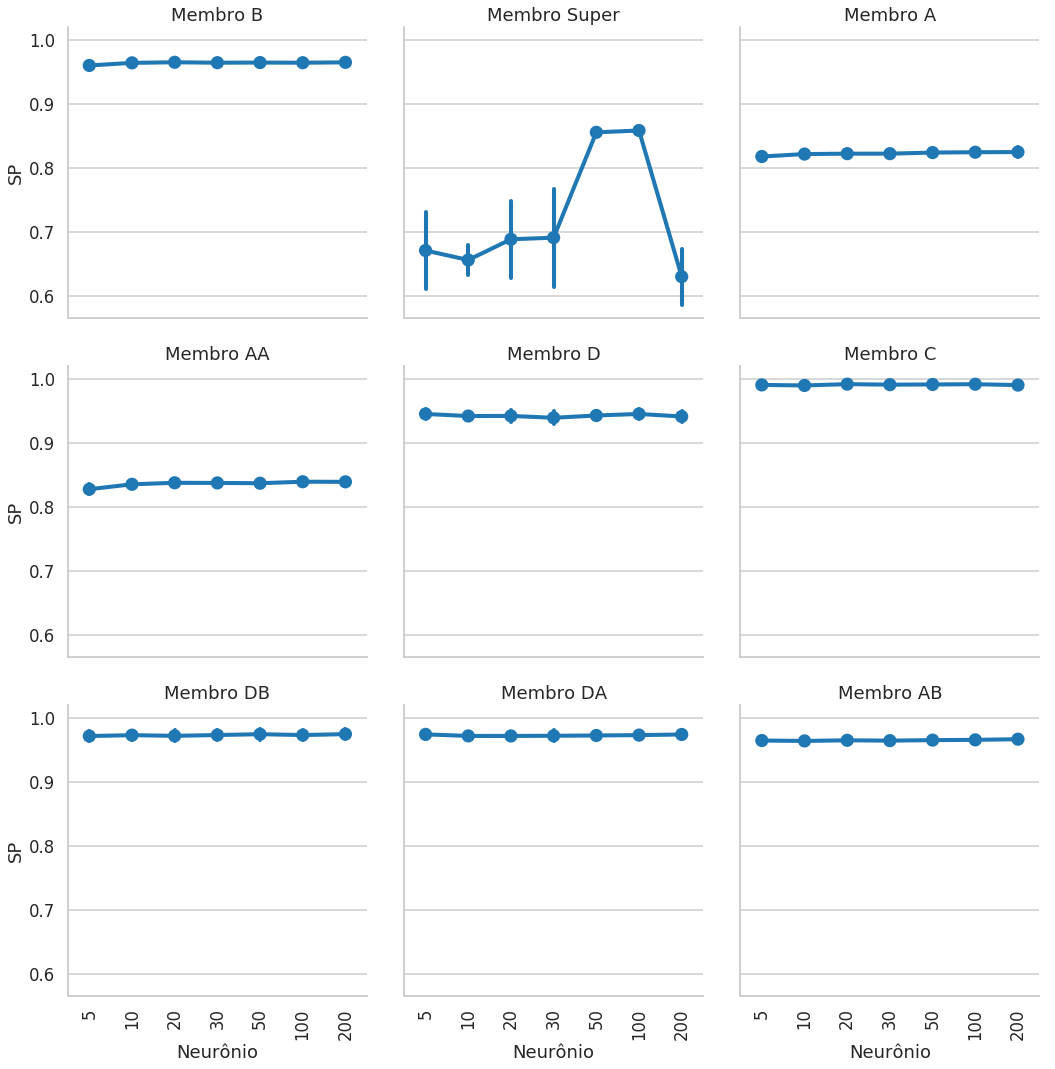

In [11]:
sns.set_style("whitegrid")
sns.set_context("talk")
data = dft.reset_index()
print data.head()
g = sns.catplot(x=u"Neuronios", y="SP",col="Membro",col_wrap=3, kind="point", ci="sd",
                    data=data)
g.set_titles("Membro {col_name}")
g.set_xticklabels(rotation=90)

for ax in g.axes.flatten()[-3:]:
    ax.set_xlabel(u"Neurônio")
if save:
    savefig(g,path_figures+'/SPXneuronXmember.png')

if save:
    savefig(g,tese_goltz+'/SPXneuronXmember.png')

# SP final of Network for each Fold

In [5]:
df_pred = {}
for ifold in range(n_folds):
    files_fold[ifold] = file_hier + '/fold0{0}'.format(ifold)
    files_class = []
    for iclass in class_name:
        file = file_hier + '/fold0{0}'.format(ifold) +'/'+iclass
        files_class.append(file)
    files[ifold] = files_class
    df_pred[ifold] = pd.read_csv(files_fold[ifold] + '/pred_all.csv')

pred_df = pd.concat(df_pred)

sp_folds = []
for ifold in range(n_folds):
    pred = pred_df.loc[ifold]['pred'].values
    table_master = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/master_table.csv')
    test_id = table_master[table_master['fold_0{0}'.format(ifold)]==1].index.values
    true = table_master['target'].values
    sp = sp_index(y_pred=pred[test_id],y_true=true[test_id])
    sp_folds.append(sp)
    #print("SP of fold {0}:{1:.2f}".format(ifold,sp))
sp_df = pd.DataFrame({'SP':sp_folds},index=['fold {0}'.format(i)for i in range(10)]).round(3)
sp_df.to_csv(file_hier+'SP.csv')
print sp_df
print("SP: {0:.3f} +- {1:.3f}".format(sp_df.mean()['SP'],sp_df.std()['SP']))
best_SP = sp_df.max()['SP']
best_fold = int(sp_df.idxmax()['SP'].split(' ')[-1])
print("best_SP: fold {} - sp {}".format(best_fold+1,best_SP))

# with  open(path_figures+'/value_SP.txt', "w") as text_file:
#     text_file.write("SP: {0:.2f} +- {1:.2f} \nbest_SP: fold {2} - sp {3}".format(sp_df.mean()['SP'],sp_df.std()['SP'],best_fold+1,best_SP))

with  open(tese_goltz+'/value_SP.txt', "w") as text_file:
    text_file.write("SP: {0:.3f} +- {1:.3f} \nbest_SP: fold {2} - sp {3}".format(sp_df.mean()['SP'],sp_df.std()['SP'],best_fold+1,best_SP))

           SP
fold 0  0.723
fold 1  0.737
fold 2  0.728
fold 3  0.739
fold 4  0.736
fold 5  0.737
fold 6  0.730
fold 7  0.736
fold 8  0.736
fold 9  0.725
SP: 0.733 +- 0.006
best_SP: fold 4 - sp 0.739


figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/fold03/class_B_train.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/fold03_class_B_train.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/fold03/class_S_train.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/fold03_class_S_train.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/fold03/class_A_train.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/927e46c14

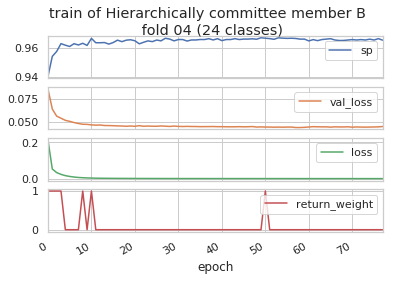

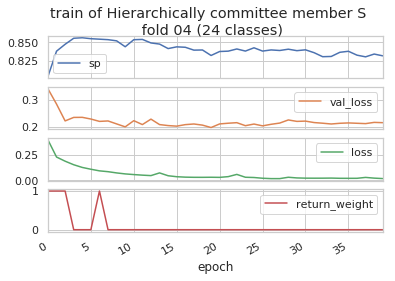

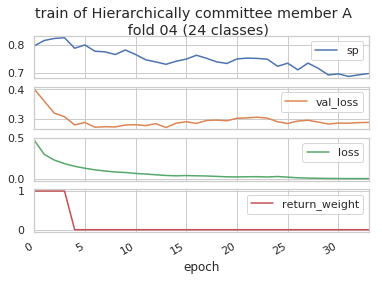

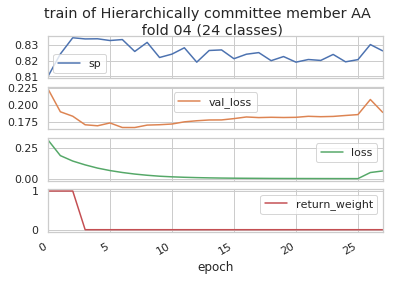

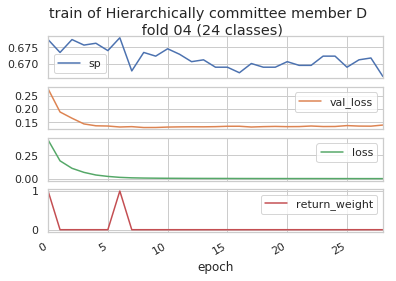

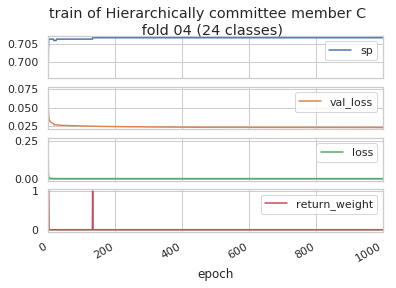

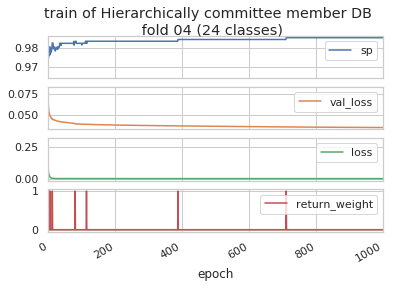

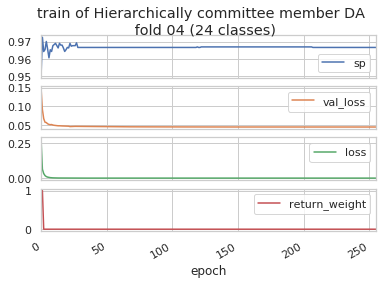

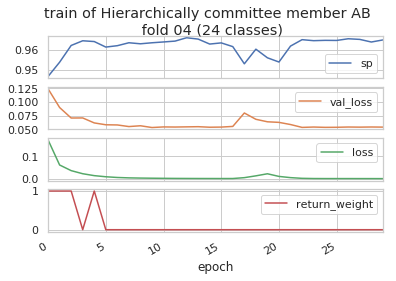

In [15]:
#train plot
import matplotlib.patches as patches
sns.set()
sns.set_style("whitegrid")
#sns.set_context("talk")

train_class = []
for ifold in [best_fold]:#range(n_folds):
    sp_folds = []
    for iclass in class_name:
        
        df = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/{0}'.format(iclass)+'/log_train.csv')
        train_class.append(df)
        
        
#         fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
#         fig.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=0.4, hspace=0.4)
        plot = df.plot(x='epoch',y=['sp','val_loss','loss','return_weight'],#'best_epoch','return_weight'],
                grid=True,#figsize=(8,5),
                subplots=True,
                title='train of Hierarchically committee member {0} \n fold {1:02d} ({2} classes)'.format(iclass.split('_')[-1],ifold+1,qtd_class))#,ax=axes)
        
        
        #fig.suptitle('train of Hierarchically committee member {0} of fold {1:02d} ({2} classes)'.format(iclass.split('_')[-1],ifold+1,qtd_class),x=1.05)
        fig = plot[0].get_figure()
        #fig.savefig("output.png")
        #savefig(plt=fig,filename=file_hier+'/fold0{0}'.format(ifold)+'/{0}'.format(iclass)+'/train.png')
        savefig(plt=fig,filename=file_hier+'/fold0{0}'.format(ifold)+'/{0}_train.png'.format(iclass))
        savefig(plt=fig,filename=tese_goltz+'/fold0{0}_{1}_train.png'.format(ifold,iclass))



#pd_tmp = pd.concat(train_class,names=['member']).reset_index().drop(['level_1'],axis=1)

# pd_tmp = pd.concat(train_class,axis=0,keys=class_name).reset_index().drop(['level_1'],axis=1)

# tmp_list = pd_tmp.columns.values
# tmp_list[0]='member'
# pd_tmp.columns = tmp_list

# sns.set_palette(sns.color_palette("deep", 20))

# t = pd.melt(pd_tmp,id_vars=['member','epoch'], var_name='train_params',  value_name='values')
# hue_order = t.train_params.unique()#[::-1]

# g = sns.catplot(x='epoch',y='values',col='member',hue='train_params',kind='point',data=t[(t['train_params']=='sp')],col_wrap=3,sharey=False,sharex=False,markers=' ',legend=False,height=4, aspect=2)
# g.set_xticklabels(rotation=90)
# g.set(xticks=t. [2::8])

# labels = hue_order
# colors = sns.color_palette("deep").as_hex()[:len(labels)]
# handles = [patches.Patch(color=col, label=lab) for col, lab in zip(colors, labels)]

# plt.legend(handles=handles, title='train_params',loc='center left', bbox_to_anchor=(1, 0.75))

# for ax in g.axes.flatten():
#     imember = ax.get_title().split('_')[-1]
#     ax.set_title('member {0}'.format(imember))
    

#savefig(plt=g,filename=file_hier+'/fold0{0}'.format(ifold)+'/train_sp.png')

figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/fold03/class_B/hist_outputNeuronXclass_fold3.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/class_B_hist_outputNeuronXclass_fold3.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/fold03/class_S/hist_outputNeuronXclass_fold3.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/class_S_hist_outputNeuronXclass_fold3.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/fold03/class_A/hist_outputNeuronXclass_fold3.pn

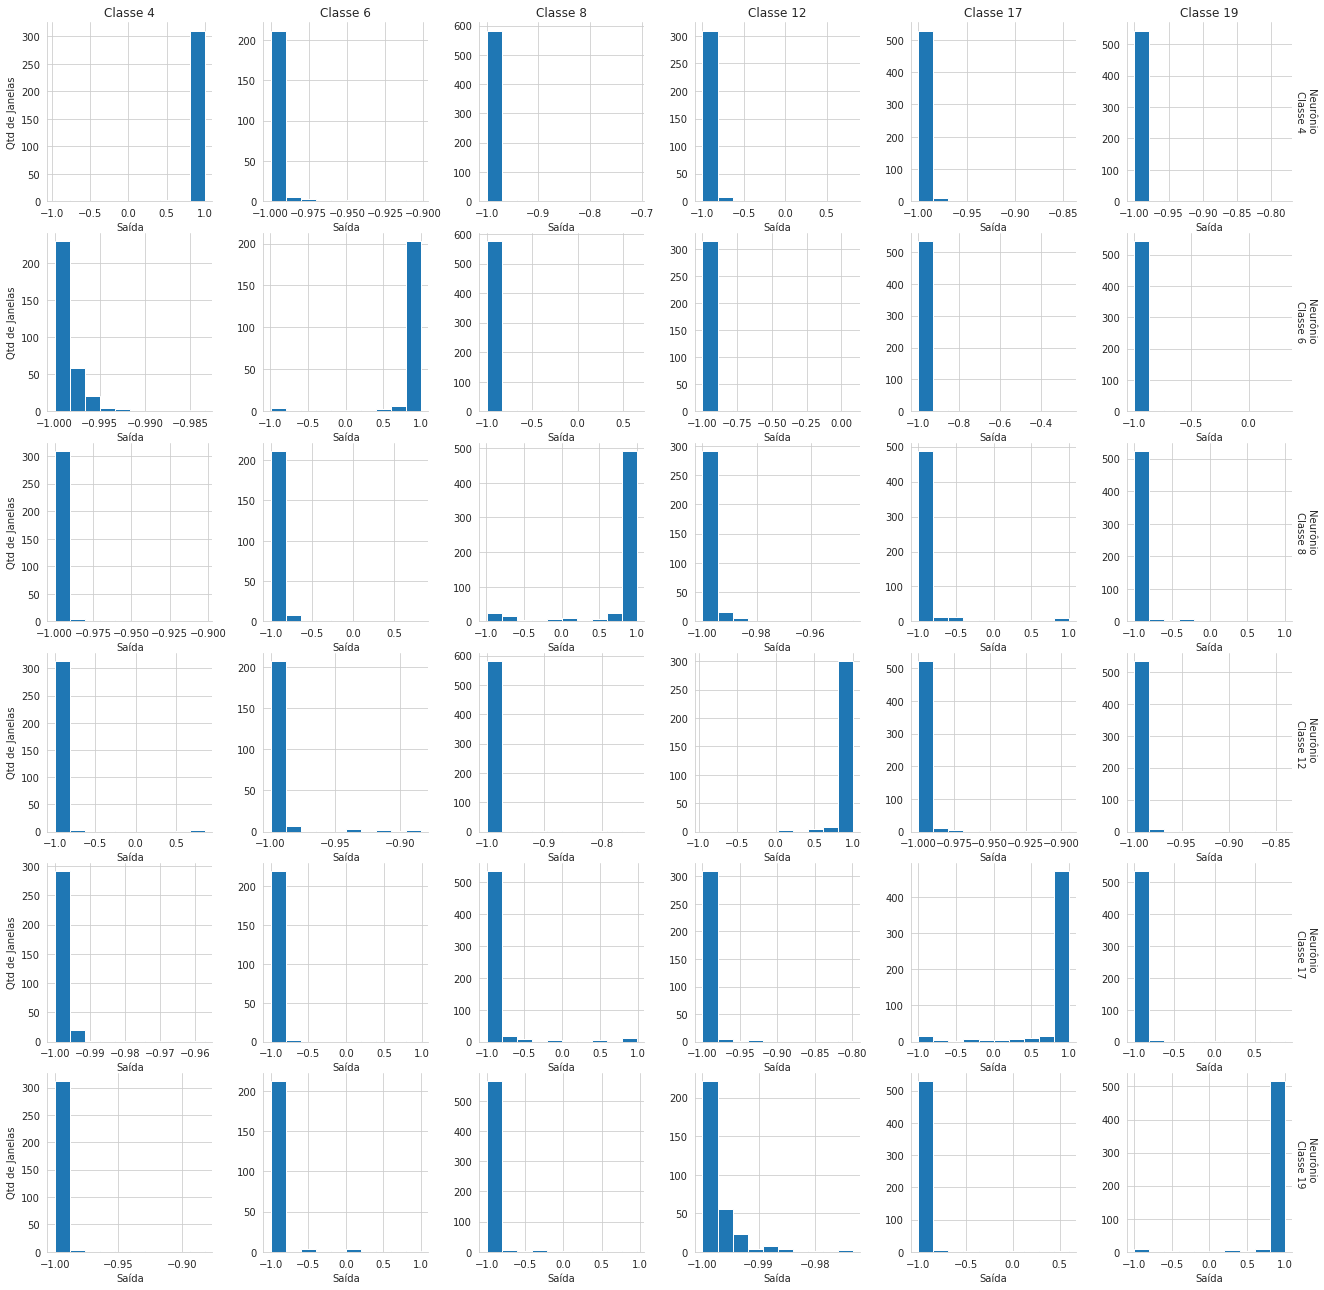

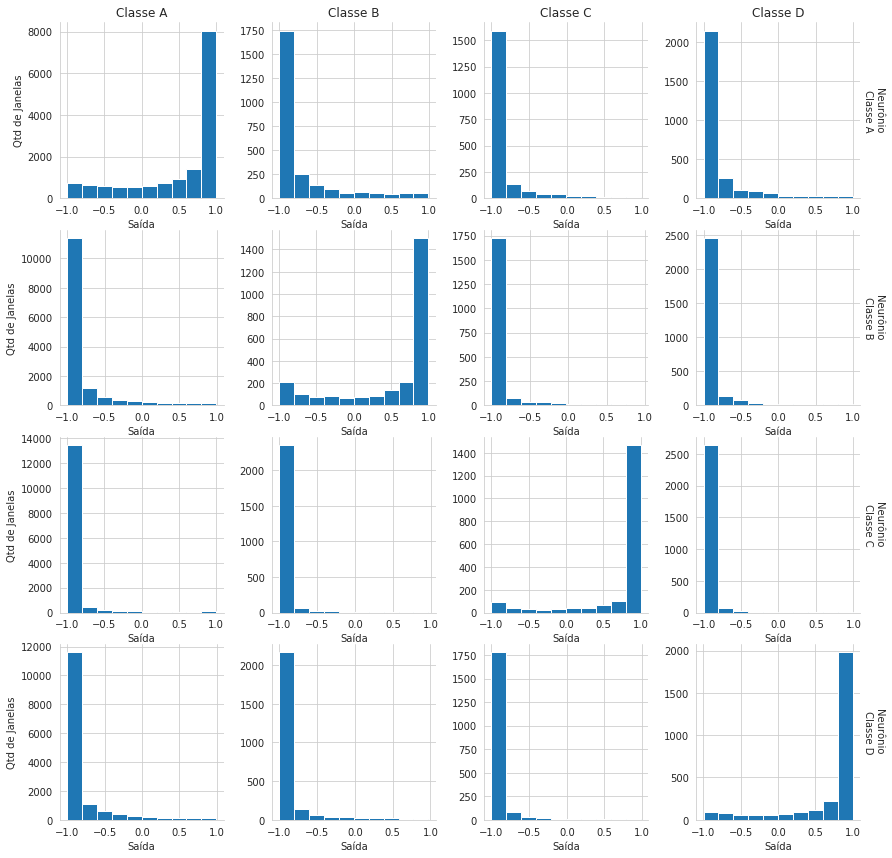

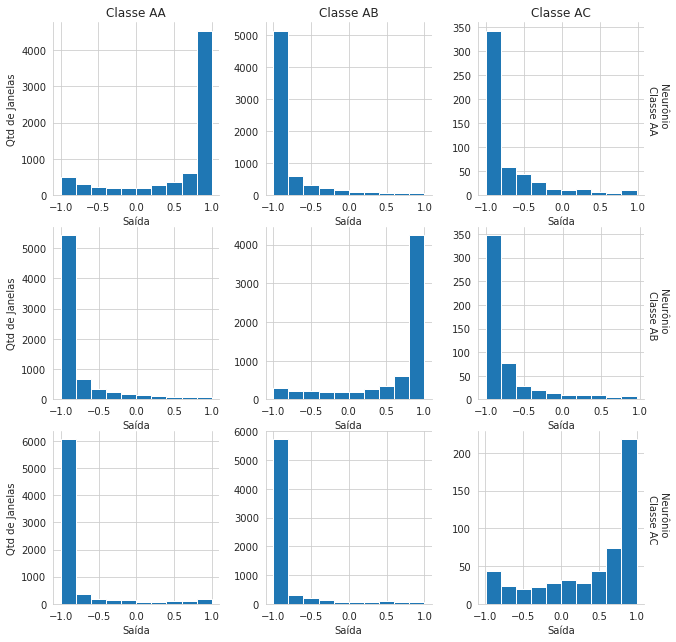

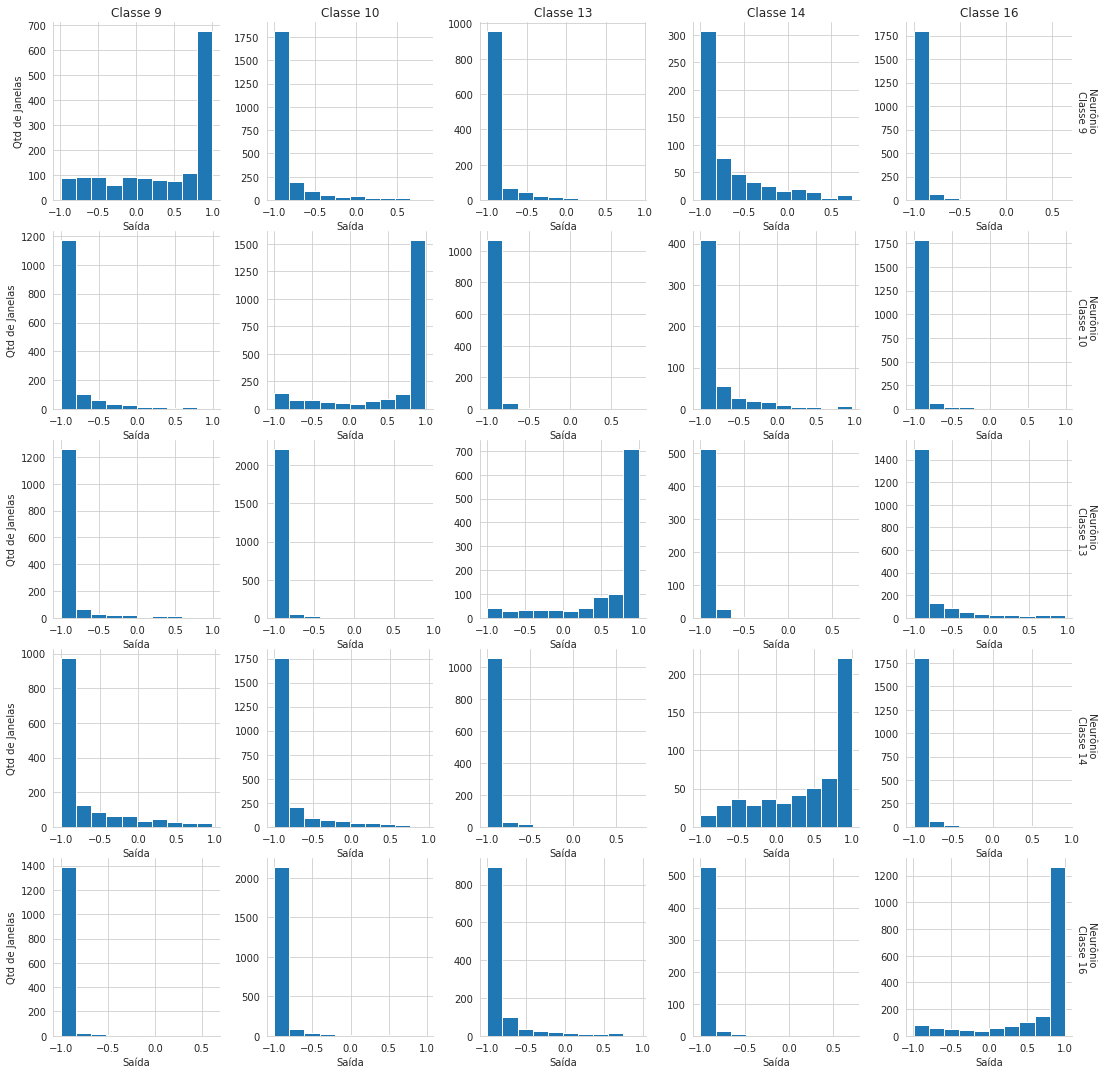

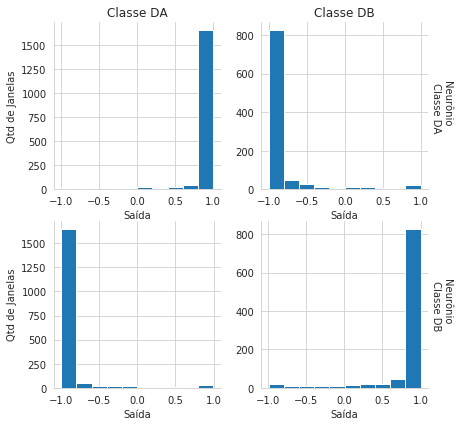

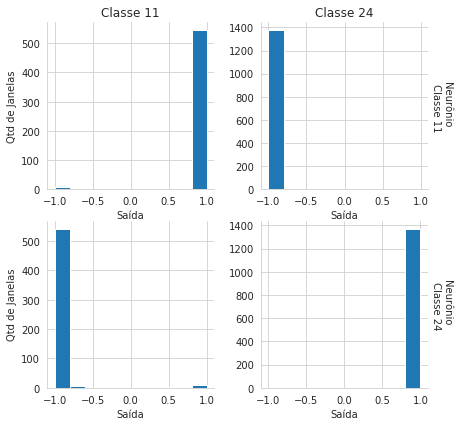

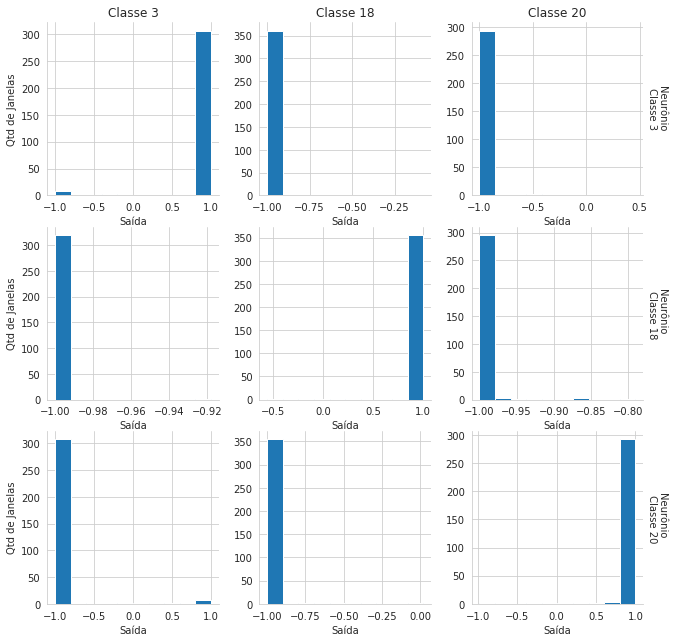

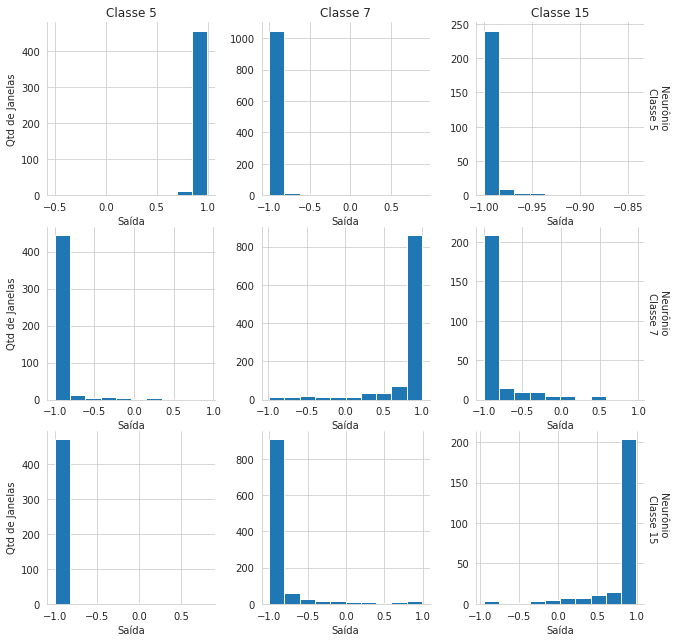

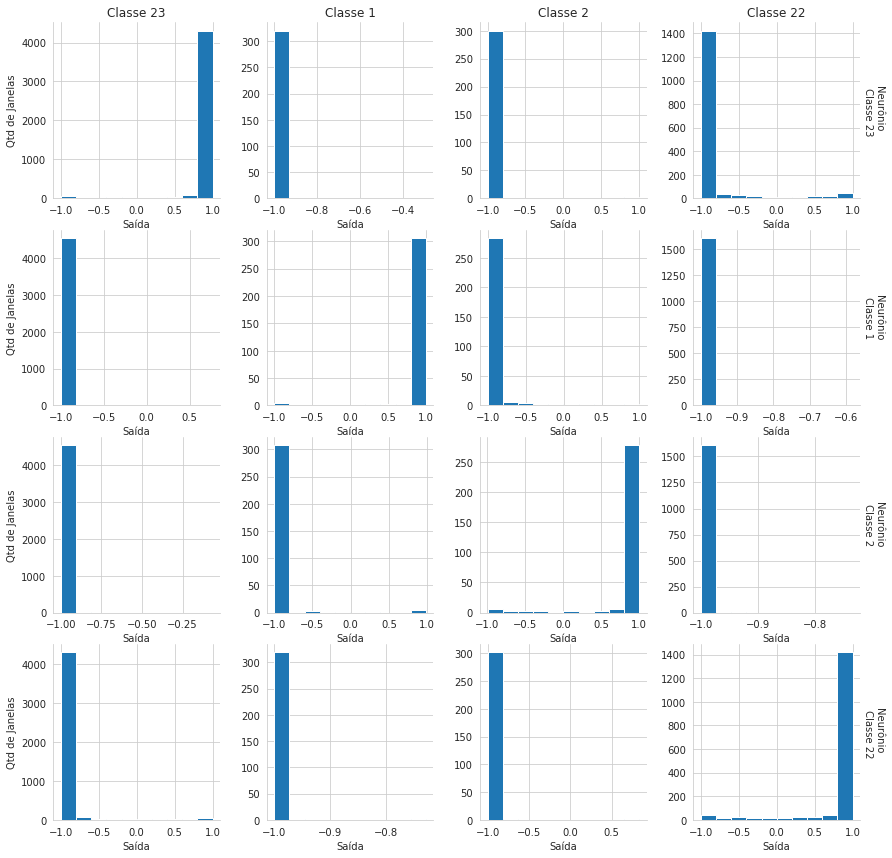

In [6]:
if database=='31classes':
    classes = [['B{0}'.format(i+1) for i in range(8)],
               [1,2,3,4],
               [i for i in range(18,32)],
               [i for i in range(13,16)],
               [i for i in range(7,12)],
               ['A','B']
              ]
else:    
    classes = [[4,6,8,12,17,19],
               ['A','B','C','D'],
               ['AA','AB','AC'],
               [9,10,13,14,16],
               ['DA','DB'],
               [11,24],
               [3,18,20],
               [5,7,15],
               [23,1,2,22]
              ]
    
sns.set_style("whitegrid")
for iclass,name_classes in zip(np.asarray(class_name),np.asarray(classes)):
    sp_folds = []
    name = iclass.split('_')[-1]
    for ifold in [best_fold]:#range(n_folds):
        
        
        pred = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/{0}'.format(iclass)+'/predict.csv')
        table_master = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/master_table.csv')
        true = table_master[(table_master[iclass]!=-1)&(table_master['fold_0{0}'.format(ifold)]==1)].index.values
        pred[iclass] = table_master[iclass]
        tmp_df = pred.loc[true,:]
        tmp2_df = pd.melt(tmp_df, id_vars=[iclass], value_vars=tmp_df.columns[:-1])


        
        g = sns.FacetGrid(tmp2_df, col=iclass, row="variable",sharey=False,sharex=False,margin_titles=True)
        g = g.map(plt.hist,'value',bins=10)
       
        #plt.subplots_adjust(top=0.95)
        #g.fig.suptitle(u"Quantidades de janelas na saída de cada neurônio do Classificador {0} (fold 0{0})".format(name,ifold))
        
        for iax,iclass2 in zip(g.axes[:,0],name_classes):
            iax.set_ylabel('Qtd de Janelas')

        for iax,iclass2 in zip(g.axes.flatten(),len(name_classes)*name_classes):
            #iax.set_title('Classe {0}'.format(iclass2))
            iax.set_xlabel(u'Saída'.format(iclass2))
            
        for iax,iclass2 in zip(g.axes[0,:],name_classes):
            iax.set_title('Classe {0}'.format(iclass2))
        
        for iax,iclass2 in zip(g.axes[:,-1],name_classes):
            if iax.texts:
                # This contains the right ylabel text
                txt = iax.texts[0]
                iax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                        u'Neurônio \n Classe {0}'.format(iclass2),
                        transform=iax.transAxes,
                        rotation=270,
                        va='center')
                        #fontsize='xx-large')
                # Remove the original text
                iax.texts[0].remove()
                
        savefig(g,file_hier+'/fold0{0}'.format(ifold)+'/{0}'.format(iclass)+'/hist_outputNeuronXclass_fold{0}.png'.format(ifold))
        savefig(plt=g,filename=tese_goltz+'/{0}_hist_outputNeuronXclass_fold{1}.png'.format(iclass,ifold))    
            
#         pred = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/{0}'.format(iclass)+'/predict.csv')
#         table_master = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/master_table.csv')
#         test_id = table_master[(table_master[iclass]!=-1)&(table_master['fold_0{0}'.format(ifold)]==1)].index.values
#         true = table_master[iclass].values
#         #true = table_master[(table_master[iclass]!=-1)][iclass].values
#         #values = pred[(table_master[iclass]!=-1)].values
#         values = pred.values


#         n_neurons = len(name_classes)
        
#         if n_neurons in [1,2,3]:
#             figsize_len = (6,6)
#         elif n_neurons in [4,5]:
#             figsize_len = (8,8)
#         elif n_neurons in [5,6,7,8]:
#             figsize_len = (10,10)
#         else:
#             figsize_len = (15,15)
        
#         fig, axes = distOutputLayer(predict=values[test_id], trgt=true[test_id],figsize=figsize_len,x_label= [u'valores da saída'.format(row+1) for row in range(n_neurons)],
#                             cols_label=[u'Classe {}'.format(col) for col in name_classes],
#                             rows_label=[u'Neurônio \n Classe {}'.format(row) for row in name_classes],
#                            suptitle=u"Quantidades de janelas na saída de cada neurônio do Classificador {0}".format(name),
#                            suptitle_kwg={'fontsize':14,'y':1.01})

#         low_label = [u'valores da saída'.format(row+1) for row in range(n_neurons)]
        
#         savefig(fig,file_hier+'/fold0{0}'.format(ifold)+'/{0}'.format(iclass)+'/hist_outputNeuronXclass_allFolds.png')

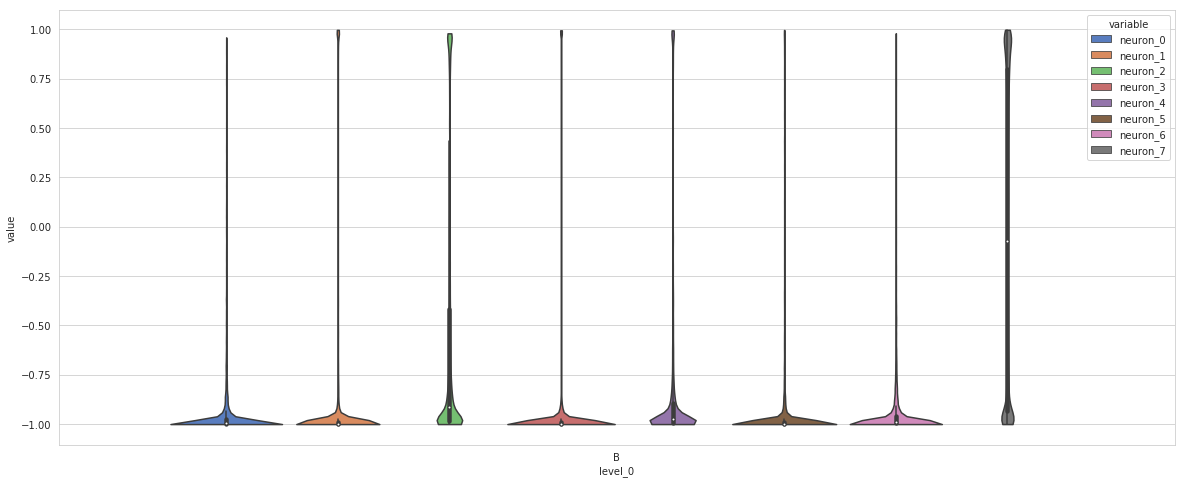

In [8]:
#violine plot

if database=='31classes':
    classes = [['B{0}'.format(i+1) for i in range(8)],
               [1,2,3,4],
               [i for i in range(18,32)],
               [i for i in range(13,16)],
               [i for i in range(7,12)],
               ['A','B']
              ]
else:    
    classes = [[4,6,8,12,17,19],
               ['A','B','C','D'],
               ['AA','AB','AC'],
               [9,10,13,14,16],
               ['DA','DB'],
               [11,24],
               [3,18,20],
               [5,7,15],
               [23,1,2,22]
              ]
    
sns.set_style("whitegrid")
vl = []
class_spec = {}
for iclass,name_classes in zip(np.asarray(class_name),np.asarray(classes)):
    sp_folds = []
    name = iclass.split('_')[-1]
    for ifold in [best_fold]:#range(n_folds):
        
        
        pred = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/{0}'.format(iclass)+'/predict.csv')
        table_master = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/master_table.csv')
        true = table_master[(table_master[iclass]!=0)&(table_master['fold_0{0}'.format(ifold)]==1)].index.values
        
        tmp_df = pred.loc[true,:]
        class_spec[iclass.split('_')[-1]]=tmp_df
        #tmp2_df = pd.melt(tmp_df, id_vars=[iclass], value_vars=tmp_df.columns[:-1])
    
    tmp = pd.concat(class_spec)      
    tmp_df = tmp.reset_index().drop(['level_1'], axis=1)
    tmp2_df = pd.melt(tmp_df, id_vars=['level_0'], value_vars=tmp_df[tmp_df.columns[1:]].columns.values)
    
    fig, ax = plt.subplots(figsize=(20,8))
    g = sns.violinplot(x="level_0", y="value", hue="variable",data=tmp2_df,ax=ax,palette="muted",cut=0, bw=.05)
    #sns.heatmap(data=tmp_df.drop(['level_0'], axis=1))
    #sns.stripplot(x="level_0", y="value", hue="variable", data=tmp2_df)
    break    
        
        
# sns.set()
# sns.set_style("whitegrid")

# vl = []
# class_spec = {}
# for trgt, iclass in enumerate(class_name):
#     for ifold in [best_fold]:#range(n_folds):
#         df_pred = pd.read_csv(file_Spec + '/fold0{0}'.format(ifold) + '/{0}'.format(iclass)+'/predict.csv')
#         table_master = pd.read_csv(file_Spec+'/fold0{0}'.format(ifold)+'/master_table.csv')
                
#         test_id = table_master[(table_master['target']==trgt)&(table_master['fold_0{0}'.format(ifold)]==1)].index.values
        
#         #df_pred[iclass] = table_master[iclass]
        
#         tmp_df = df_pred.loc[test_id,:]
#         class_spec[iclass.split('_')[0]]=tmp_df
        
#     print "finished {}".format(iclass)
#     tmp = pd.concat(class_spec)      
#     tmp_df = tmp.reset_index()
#     tmp_df.drop(['level_1'], axis=1)
#     tmp2_df = pd.melt(tmp_df, id_vars=['level_0'], value_vars=['neuron_1','neuron_0'])
# # tmp2_df

#     #g = sns.FacetGrid(tmp2_df, col='variable', row="level_0",sharey=False,sharex=False,margin_titles=True)
#     #g = g.map(plt.hist,'value',bins=10)
# fig, ax = plt.subplots(figsize=(20,8))

# g = sns.violinplot(x="level_0", y="value", hue="variable",data=tmp2_df,ax=ax,palette="muted",cut=0, bw=.05)
# #g = sns.swarmplot(x="level_0", y="value", hue="variable",data=tmp2_df,ax=ax1,size=1)#,palette="muted")

# #g = sns.stripplot(x="level_0", y="value", hue="variable",data=tmp2_df,ax=ax, palette=sns.color_palette(['red','blue']), dodge=True ,alpha=0.2)
# #g = sns.boxenplot(x="level_0", y="value", hue="variable",data=tmp2_df,ax=ax)

# ax.axes.set_xlabel('Especialistas')
# ax.axes.set_ylabel(u'Valores da Saída Especialista')
# ax.set_xticklabels(["{0:02d}".format(int(i.split("_")[0])+1)for i in class_name])
# #g.legend(['classe','n_classe'])
# g.legend_.set_title('classe')
# new_labels = ['Sim', u'Não']
# for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)
# plt.xticks(rotation=90)
# savefig(fig,file_Spec+'/fold0{0}'.format(ifold)+'/{0}'.format(iclass)+'/cut_violine_outputNeuronXclass_fold{0}.png'.format(ifold))
# savefig(plt=fig,filename=tese_goltz+'/{0}_cut_violine_outputNeuronXclass_fold{1}.png'.format(iclass,ifold))
# # print tmp_2.head()
# #print tmp_df.head()

finished Comite
finished class_B
finished class_S
finished class_A
finished class_AA
finished class_D
finished class_C
finished class_DB
finished class_DA
finished class_AB
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/SP_each_classes_pt.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/SP_cada_membro_hierarquico_pt.png file


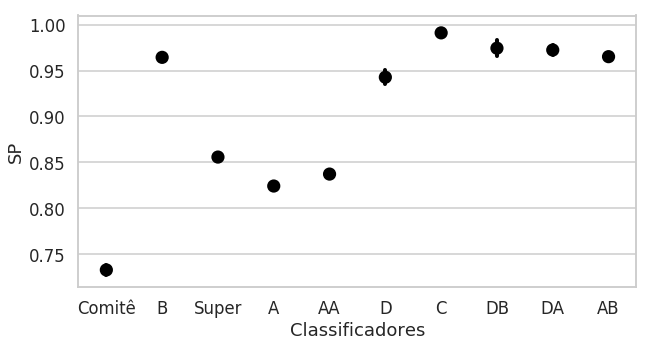

In [7]:
sns.set_style("whitegrid")
sns.set_context("talk")
class_tmp = ['class_Super' if x=='class_S' else x for x in class_name]

sp_all = []
for iclass in ['Comite']+class_name :
    for ifold in range(n_folds):
        df_pred = pd.read_csv(file_hier + '/fold0{0}'.format(ifold) + '/pred_all.csv')
        table_master = pd.read_csv(file_hier +'/fold0{0}'.format(ifold)+'/master_table.csv')
        if iclass=='Comite':
            test_id = table_master[table_master['fold_0{0}'.format(ifold)]==1].index.values
            true = table_master.loc[test_id,'target'].values
            pred = df_pred.loc[test_id,'pred'].values
        else:
            
            test_id = table_master[(table_master[iclass]!=-1)&(table_master['fold_0{0}'.format(ifold)]==1)].index.values
            true = table_master.loc[test_id,iclass].values
            pred = df_pred.loc[test_id,iclass].values

        sp = sp_index(y_pred=pred,y_true=true)
        sp_all.append(sp)
    print "finished {}".format(iclass)

idxs = pd.MultiIndex.from_product(iterables=[['Comite']+["{0}".format(i.split('_')[-1]) for i in class_tmp],range(1,11)],names=['member','folds'])

dft = pd.DataFrame({'SP':sp_all},index=idxs)
data = dft.reset_index()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

sns.pointplot(x="member", y=u'SP',markers='o', kind="line", ci="sd", data=data, color='k', markerfacecolor='g', linestyles=' ', ax=ax)

#ax.set_title(u"Classe Hierarquica",fontsize=15)
ax.set_xlabel(u"Classificadores")
ax.axes.set_xticklabels([u'Comitê']+["{0}".format(i.split('_')[-1]) for i in class_tmp])

savefig(plt,file_hier +'/SP_each_classes_pt.png')
savefig(plt=plt,filename=tese_goltz+'/SP_cada_membro_hierarquico_pt.png')

# Confusion Matrix of each Class

figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/confusion_matrix_sns_B.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/confusion_matrix_sns_B.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/confusion_matrix_sns_Super.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/confusion_matrix_sns_Super.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/confusion_matrix_sns_A.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification

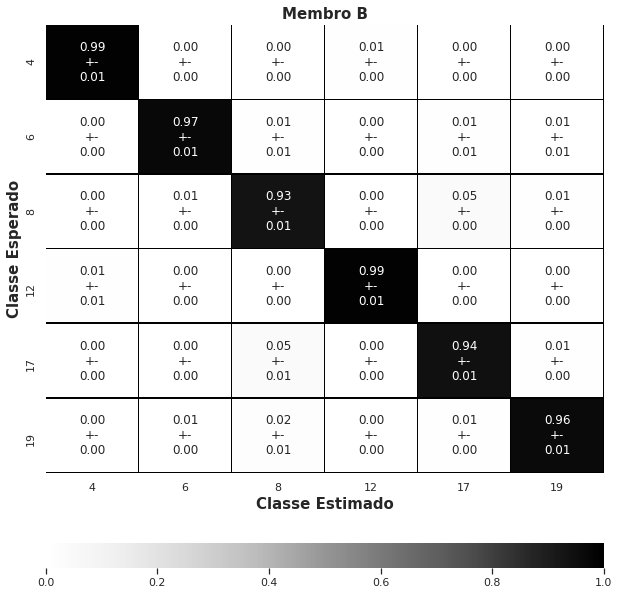

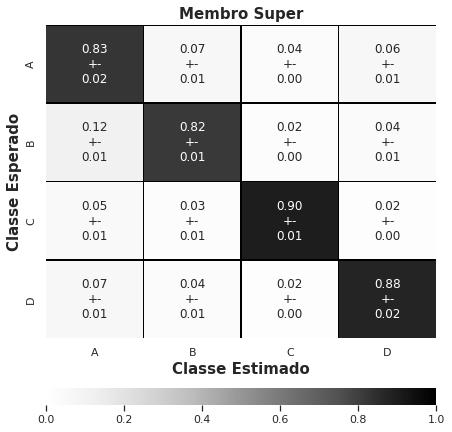

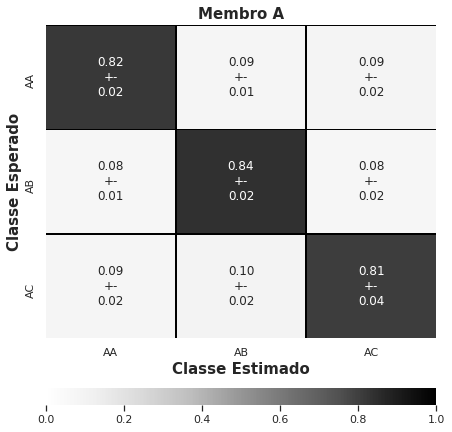

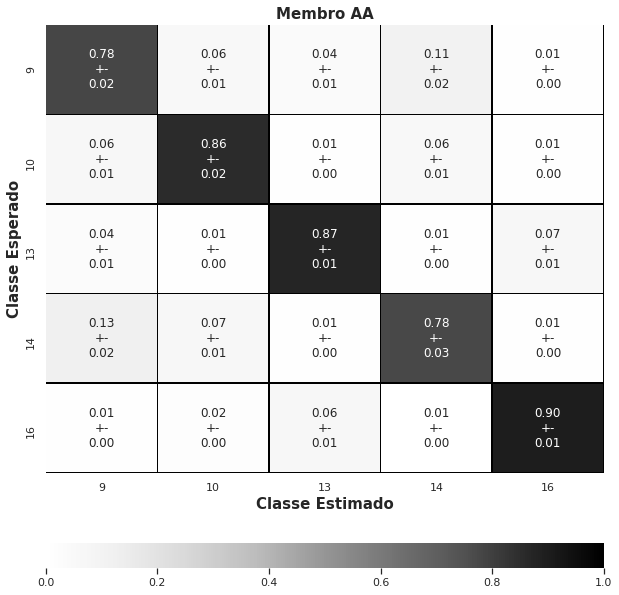

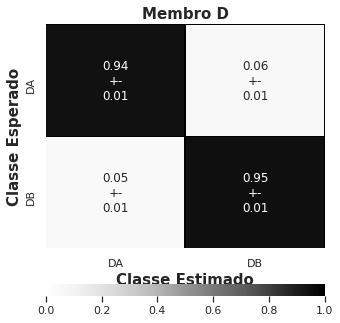

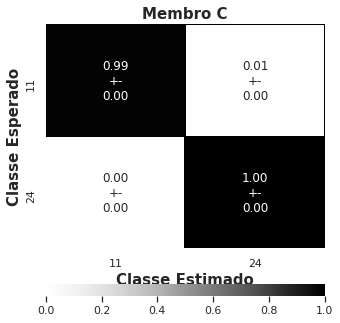

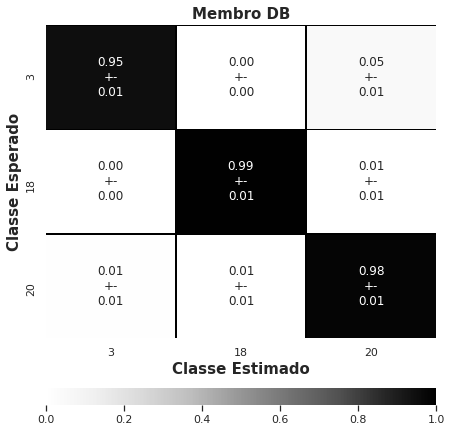

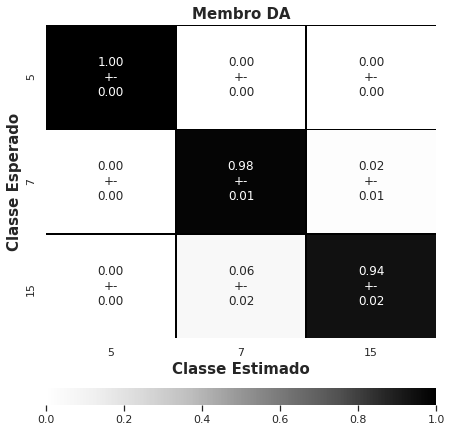

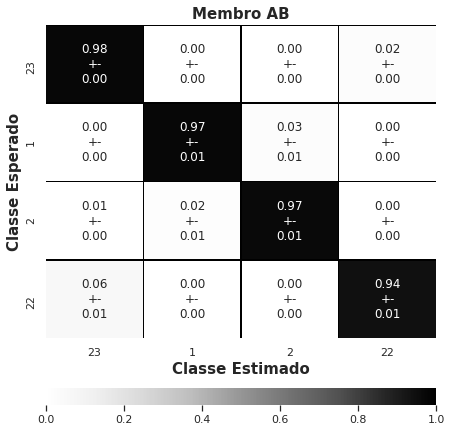

In [6]:
if database=='31classes':
    classes = [['B{0}'.format(i+1) for i in range(8)],
               [1,2,3,4],
               [i for i in range(18,32)],
               [i for i in range(13,16)],
               [i for i in range(7,12)],
               ['A','B']
              ]
else:    
    classes = [[4,6,8,12,17,19],
               ['A','B','C','D'],
               ['AA','AB','AC'],
               [9,10,13,14,16],
               ['DA','DB'],
               [11,24],
               [3,18,20],
               [5,7,15],
               [23,1,2,22]
              ]

sns.set()
sns.set_style("whitegrid")
for iclass,name_classes in zip(np.asarray(class_name),np.asarray(classes)):
    cm_folds = []
    name = iclass.split('_')[-1]
    for ifold in range(n_folds):
        
#         pred = pred_df.loc[ifold]['pred'].values
#         table_master = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/master_table.csv')
#         test_id = table_master[table_master['fold_0{0}'.format(ifold)]==1].index.values
#         true = table_master['target'].values
        
        
        #pred_df = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/pred_all.csv')
        table_master = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/master_table.csv')
        
        test_id = table_master[(table_master[iclass]!=-1)&(table_master['fold_0{0}'.format(ifold)]==1)].index.values
        
        pred = table_master.loc[test_id,'{}_pred'.format(iclass)]
        
        true = table_master.loc[test_id,iclass]
        
        
        
        
        
        
        confusionMatrix = confusion_matrix(y_pred=pred,y_true=true)
        cm_norm = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]

        cm_folds.append(cm_norm)
    
    if database=='31classes':
        fig_size = 30
    else:
        fig_size = 25

    
    
    if len(name_classes)<=2:
        fig_size = 5
        grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
    elif len(name_classes)<=4:
        fig_size = 7
        grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
    elif len(name_classes)<=8:
        fig_size = 10
        grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
    elif len(name_classes)<=15:
        fig_size = 15
        grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
    
    f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws,figsize=(fig_size,fig_size))

    
    xy_labels = name_classes#['C{0}'.format(i+1) for i in range(int(qtd_class))]
    
    if name=='S':
        name = 'Super'
    
    snsConfusionMatrix(cm_norm=cm_folds,ax=ax,
                       ylabel_kwg={'ylabel':'Classe Esperado'},
                       xlabel_kwg={'xlabel':'Classe Estimado'},
                       title_kwg={'label':u'Membro {0}'.format(name)},
                       x_labels=xy_labels,
                       y_labels=xy_labels,
                       sns_kwg={'cbar_ax':cbar_ax,'cbar':True, 'cbar_kws':{"orientation": "horizontal"} })
    
    
    fig_cm = file_hier + '/confusion_matrix_sns_{}.png'.format(name)
    savefig(f,fig_cm)
    savefig(plt=f,filename=tese_goltz+'/confusion_matrix_sns_{}.png'.format(name))

# predict HierarqNet

figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/confusion_matrix_sns.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/confusion_matrix_sns.png file


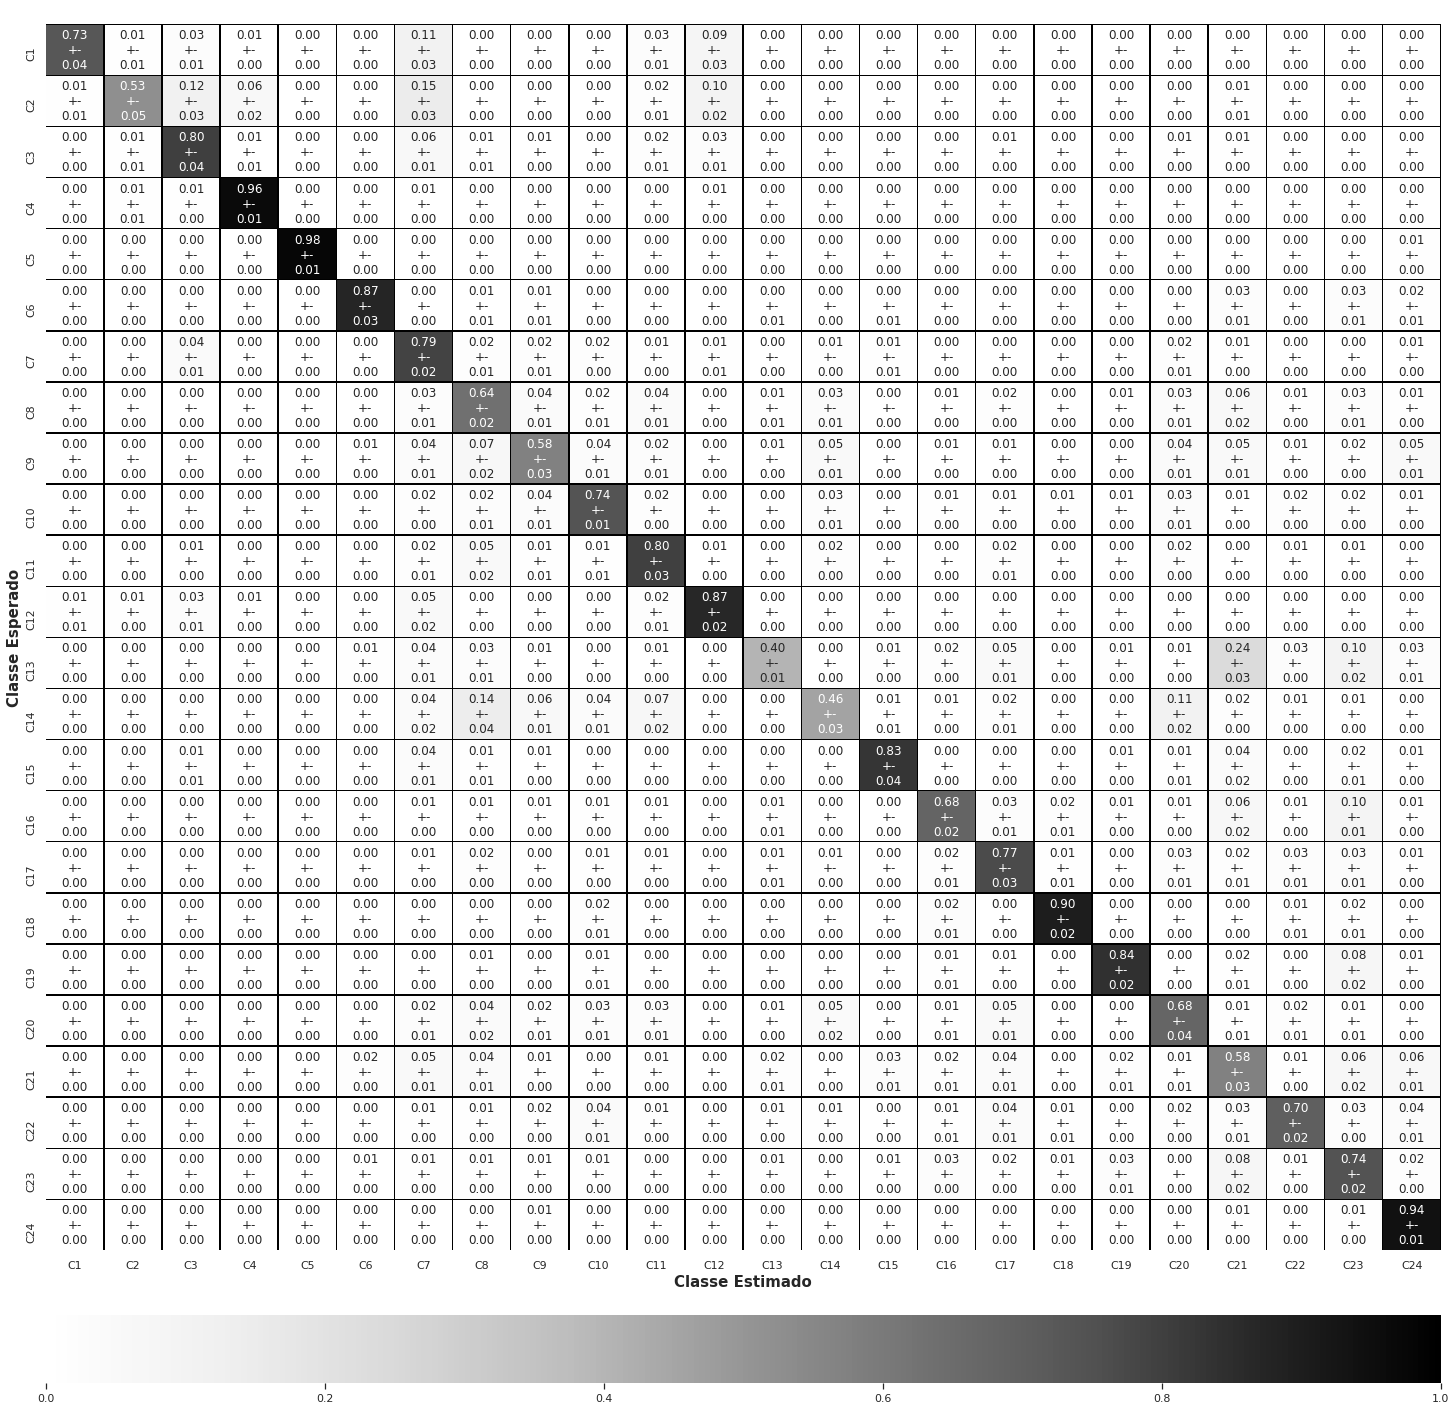

In [7]:
#fig, ax = plt.subplots(figsize=(30,30))

#plotConfusionMatrix(pred, true, class_labels=['Classe {0:02d}'.format(i+1) for i in range(24)], ax=ax)
#work with only pred_df and table_master
sns.set()
cm_folds = []
for ifold in range(n_folds):
    pred = pred_df.loc[ifold]['pred'].values
    table_master = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/master_table.csv')
    test_id = table_master[table_master['fold_0{0}'.format(ifold)]==1].index.values
    true = table_master['target'].values
    confusionMatrix = confusion_matrix(y_pred=pred[test_id],y_true=true[test_id])
    cm_norm = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
    
    cm_folds.append(cm_norm)
if database=='31classes':
    fig_size = 30
else:
    fig_size = 25

    
# ax = fig.add_subplot(111)
# ax.set_aspect(1)

# cbar_ax = fig.add_axes([.905, .3, .05, .3])

grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws,figsize=(fig_size,fig_size))

snsConfusionMatrix(cm_norm=cm_folds,ax=ax,title_kwg={'label':" "},
                   ylabel_kwg={'ylabel':'Classe Esperado'},
                   xlabel_kwg={'xlabel':'Classe Estimado'},
                   x_labels=['C{0}'.format(i+1) for i in range(int(qtd_class))],
                   y_labels=['C{0}'.format(i+1) for i in range(int(qtd_class))],
                   sns_kwg={'cbar_ax':cbar_ax,'cbar':True, 'cbar_kws':{"orientation": "horizontal"} })


#plt.title('Confusion matrix of HierarqNet using MLP as estimator',fontsize=20,fontweight="bold")
fig_cm = file_hier + '/confusion_matrix_sns.png'
savefig(f,fig_cm)
savefig(plt=f,filename=tese_goltz+'/confusion_matrix_sns.png')

figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/recall_each_classes_en.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/recall_each_classes_pt.png file


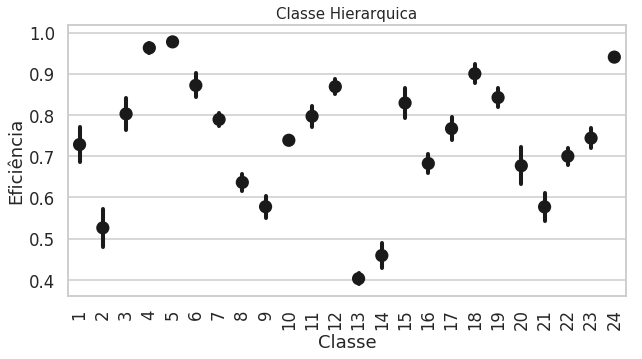

In [10]:
from sklearn.metrics import recall_score

recall_all = []
for ifold in range(n_folds):
    table_master = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/master_table.csv')
    df_pred = pd.read_csv(file_hier + '/fold0{0}'.format(ifold) + '/pred_all.csv')
    
    test_id = table_master[(table_master['fold_0{0}'.format(ifold)]==1)].index.values
        
    pred_test = df_pred.loc[test_id,:]['pred'].values
    true_test = table_master.loc[test_id,:]['target'].values
        
    #sp = sp_index(y_pred=pred_test,y_true=true_test)
    recall = recall_score(y_pred=pred_test,y_true=true_test,average=None)
    
    [recall_all.append(i)for i in recall]


idxs = pd.MultiIndex.from_product(iterables=[map(lambda x:x+1,range(n_folds)),map(lambda x:x+1,range(len(recall)))],names=['folds','Classe'])
df_test = pd.DataFrame({u'Eficiência':recall_all},index=idxs)

sns.set_style("whitegrid")
sns.set_context("talk")

data = df_test.reset_index()#query("member=='class_B'").reset_index()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

g = sns.pointplot(x="Classe", y=u'Eficiência',markers='o', kind="line", ci="sd", data=data, color='k', markerfacecolor='g', linestyles=' ', ax=ax)

#g.grid()

for item in g.get_xticklabels():
    item.set_rotation(90)

ax.set_title(u"Classe Hierarquica",fontsize=15)

# recall_folds = []
# for ifold in range(n_folds):
#     pred = pred_df.loc[ifold]['pred'].values
#     table_master = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/master_table.csv')
#     test_id = table_master[table_master['fold_0{0}'.format(ifold)]==1].index.values
#     true = table_master['target'].values
#     recall = recall_score(y_pred=pred[test_id],y_true=true[test_id],average=None)
    
    
#     recall_folds.append(recall)

# recall_mean = np.asarray(recall_folds).mean(axis=0)
# recall_std = np.asarray(recall_folds).std(axis=0)

# fig, ax = plt.subplots(figsize=(10,5))

# plt.errorbar(x=['{0:02d}'.format(i+1) for i in range(24)],y=recall_mean,
#              yerr=recall_std,
#              marker='o',
#              color='k',
#              ecolor='k',
#              markerfacecolor='g',
#              capsize=0,
#              linestyle='None',label=None)
#s_fig.grid()
#s_fig.set_xticks("Classes")#,fontsize=30)
# s_fig.ylabel(u"Efficiency",fontsize=30)
# s_fig.yticks(fontsize=14)
# s_fig.xticks(fontsize=14)

# plt.legend()
savefig(plt,file_hier +'/recall_each_classes_en.png')
savefig(plt=plt,filename=tese_goltz+'/recall_each_classes_pt.png')

# Specifics Cases

In [5]:
sns.set()
sns.set_style("whitegrid")

    
specifics_classes = []
    
sp_all = []
for iclass in class_name:
    for ifold in range(n_folds):
        df_pred = pd.read_csv(file_hier + '/fold0{0}'.format(ifold) + '/pred_all.csv')
        pred = df_pred[iclass].values
        table_master = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/master_table.csv')
        test_id = table_master[(table_master[iclass]!=-1)&(table_master['fold_0{0}'.format(ifold)]==1)].index.values
        true = table_master[iclass].values
        
        sp = sp_index(y_pred=pred[test_id],y_true=true[test_id])
        sp_all.append(sp)
    print "Finish {}".format(iclass)
idxs = pd.MultiIndex.from_product(iterables=[["{0}".format(i.split('_')[-1]) for i in class_name],range(1,11)],names=['member','folds'])
# idxs = ["{0}".format(i.split('_')[-1]) for i in class_name]
df_restrict = pd.DataFrame({'sp':sp_all},index=idxs)

Finish class_B
Finish class_S
Finish class_A
Finish class_AA
Finish class_D
Finish class_C
Finish class_DB
Finish class_DA
Finish class_AB


In [7]:
save_flag = True

list_tuple = []
count_values = []
for iclass in range(int(qtd_class)):
    for ifold in range(n_folds):
        
        df_pred = pd.read_csv(file_hier + '/fold0{0}'.format(ifold) + '/pred_all.csv')
        
        table_master = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/master_table.csv')
        
        id = table_master[(table_master['target']==iclass)&(table_master['fold_0{0}'.format(ifold)]==1)].index.values
        n_windows = df_pred.loc[id,:]['pred'].shape[0]
        x = df_pred.loc[id,:]['pred'].value_counts().index.values
        y = df_pred.loc[id,:]['pred'].value_counts().values
        
        for ix,iy in zip(x,y):
            list_tuple.append((iclass+1,ifold+1,ix+1))
            count_values.append(iy)
            
        
        
    print "Finish {}".format(iclass)

idx = pd.MultiIndex.from_tuples(tuples=list_tuple,names=['refClasse','folds','classe'])
df_preCLass = pd.DataFrame({'Qtd de Janelas':count_values},index=idx)

Finish 0
Finish 1
Finish 2
Finish 3
Finish 4
Finish 5
Finish 6
Finish 7
Finish 8
Finish 9
Finish 10
Finish 11
Finish 12
Finish 13
Finish 14
Finish 15
Finish 16
Finish 17
Finish 18
Finish 19
Finish 20
Finish 21
Finish 22
Finish 23


figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/Histograma_ativacao_classe_1.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/Histograma_ativacao_classe_1.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/Histograma_ativacao_classe_2.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/Histograma_ativacao_classe_2.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/Histograma_ativacao_classe_3.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/

/home/venancio/sonarteste/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/Histograma_ativacao_classe_21.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/Histograma_ativacao_classe_21.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/Histograma_ativacao_classe_22.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/Figures/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/Histograma_ativacao_classe_22.png file
figure was saved in /home/venancio/Workspace/SonarAnalysis/Results/Classification/927e46c140e22b3e4e0d5f3777cbd9ea7097535153009d3b9657a534fe37287a/Histograma_ativacao_classe_23.png file
figure was saved in /home/venancio/Workspace/SonarAnal

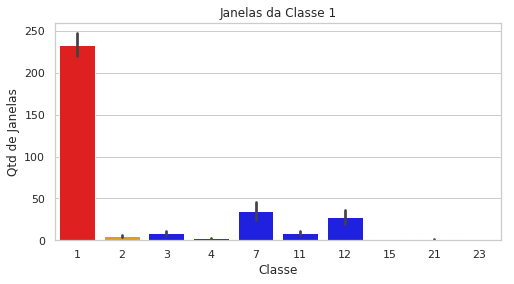

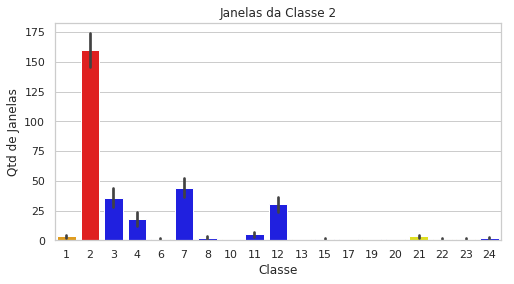

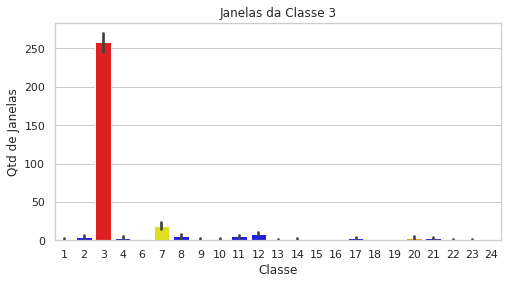

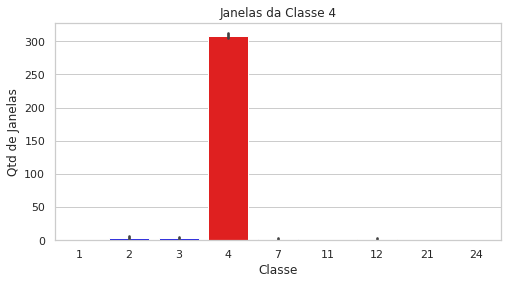

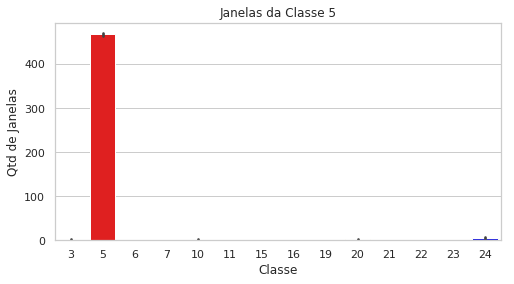

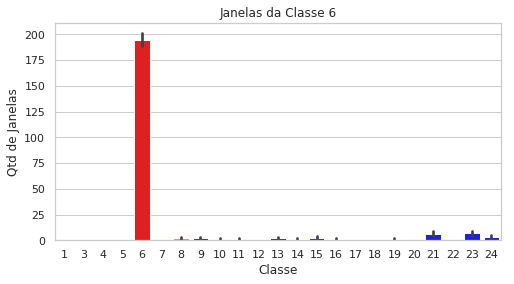

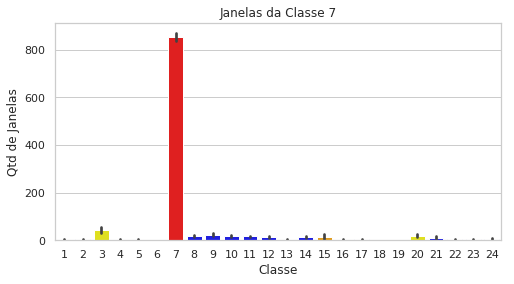

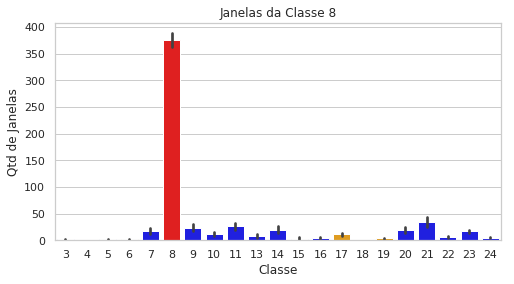

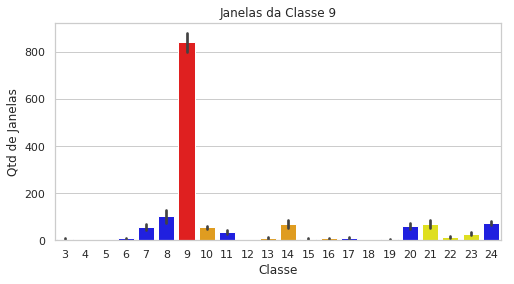

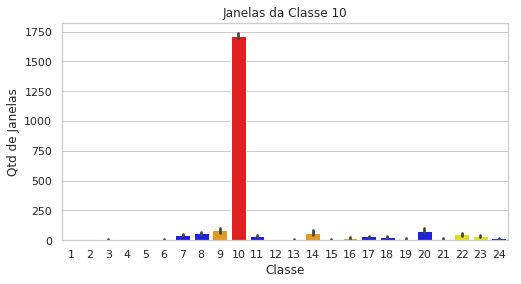

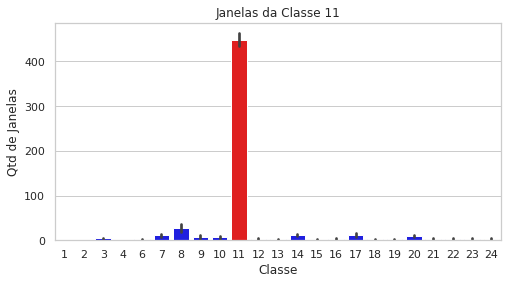

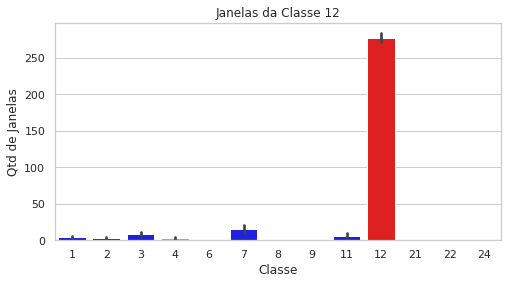

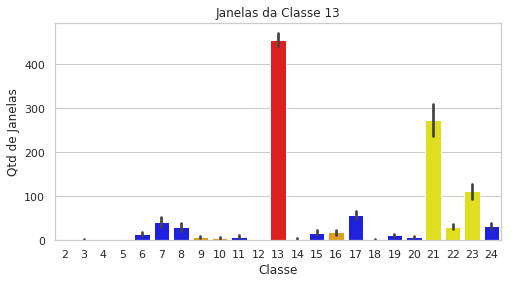

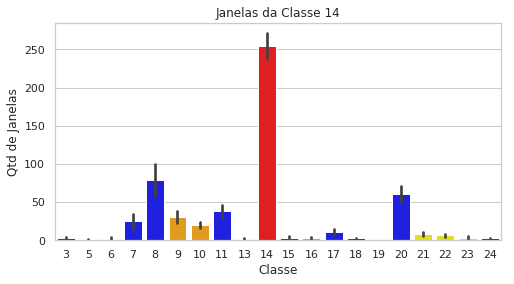

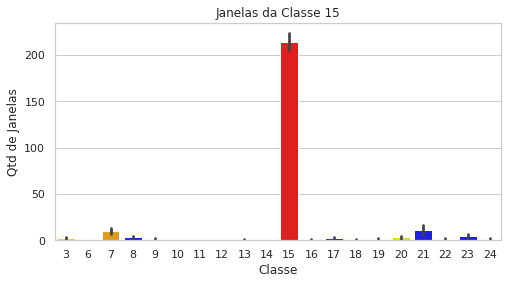

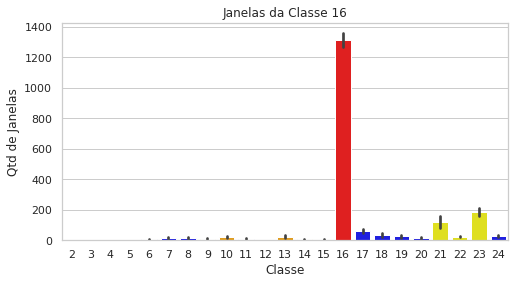

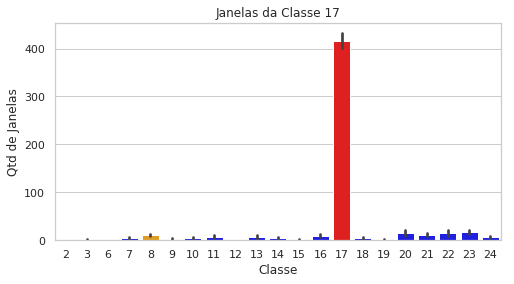

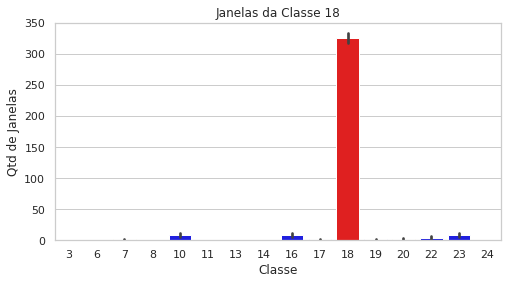

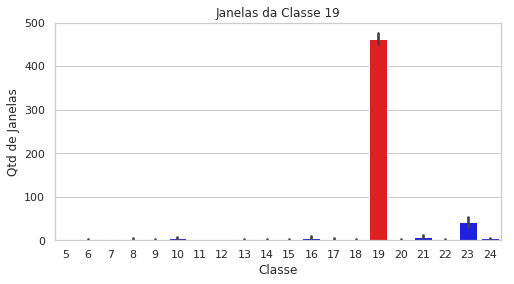

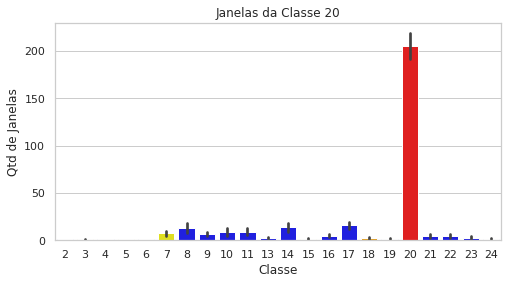

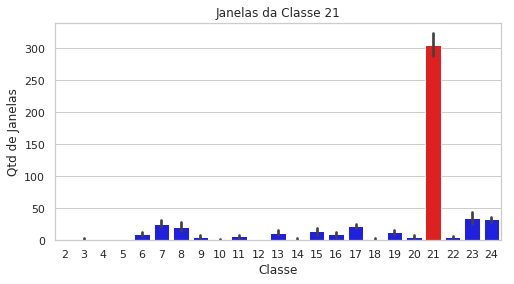

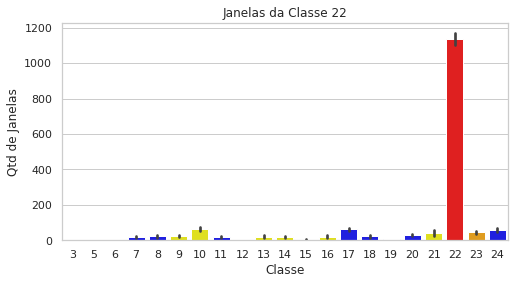

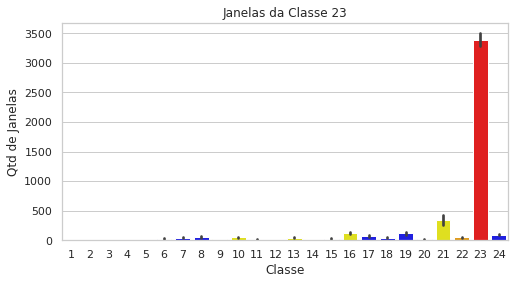

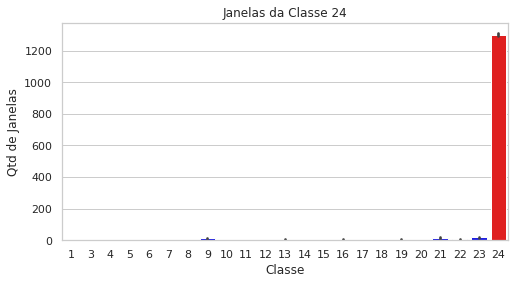

In [8]:
sns.set()
sns.set_style("whitegrid")


data = df_preCLass.reset_index()

if database=='31classes':
    same_lvl = []
    lvl_above = []
    
    for iclass in range(1,int(qtd_class)+1):
        lvl_above.append([])
        if iclass in range(1,5):
            same_lvl.append(range(1,5))
            
        
        if iclass in [5,6,12,16,17]:
            same_lvl.append([])
           
        
        if iclass in range(7,12):
            same_lvl.append(range(7,12))
            
        if iclass in range(13,16):
            same_lvl.append(range(13,16))
        
        if iclass in range(18,32):
            same_lvl.append(range(18,32))
        
else:    
    same_lvl = []
    lvl_above = []
    
    for iclass in range(1,int(qtd_class)+1):
        #AB
        if iclass in [1,2,22,23]:
            same_lvl.append([1,2,22,23])
            lvl_above.append([9,10,13,14,16,1,2,22,23,21])
        #DB
        if iclass in [3,18,20]:
            same_lvl.append([3,18,20])
            lvl_above.append([5,7,15])
        #DA    
        if iclass in [5,7,15]:
            same_lvl.append([5,7,15])
            lvl_above.append([3,18,20])
        
        #B
        if iclass in [4,6,8,12,17,19]:
            same_lvl.append([4,6,8,12,17,19])
            lvl_above.append([])
            
        #C
        if iclass in [11,24]:
            same_lvl.append([11,24])
            lvl_above.append([])
           
        #AA
        if iclass in [9,10,13,14,16]:
            same_lvl.append([9,10,13,14,16])
            lvl_above.append([9,10,13,14,16,1,2,22,23,21])
            
        #AC
        if iclass in [21]:
            same_lvl.append([])
            lvl_above.append([])
        

for iclass,isame,iabove in zip(range(int(qtd_class)),same_lvl,lvl_above):
    idata = data[data['refClasse']==iclass+1]
    all_classes = sorted(idata.classe.unique())
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.8)
    ax = axes
    
    colors = []
    for i in np.unique(idata['classe']):
        color='blue'
        
        if i in iabove:
            color = 'yellow'
        
        if i in isame:
            color = 'orange'
        
        if i==(iclass+1):
            color = 'red'
            
        colors.append(color)
            
    g = sns.barplot(y='Qtd de Janelas',x='classe',ax=ax,data=idata,ci='sd',palette=sns.color_palette(colors))
    g.set_xlabel('Classe')
    g.set_title('Janelas da Classe {}'.format(iclass+1))
    
    if save_flag: savefig(fig, file_hier +  '/Histograma_ativacao_classe_{0}.png'.format(iclass+1))
    if save_flag: savefig(plt=fig,filename=tese_goltz+'/Histograma_ativacao_classe_{0}.png'.format(iclass+1))

In [ ]:
def flatten_listOflist(list_):
    return [y for x in list_ for y in x]




if database=='31classes':
    
    
    info_ = [
    ('class_S','class_A',0,LabelEncoder().fit(["{}".format(i) for i in range(1,5)])),
    ('class_S','class_B',1,LabelEncoder().fit(["{}".format(i) for i in range(5,32)])),
    ('class_B','class_B8',7,LabelEncoder().fit(["{}".format(i) for i in range(18,32)])),
    ('class_B','class_B5',4,LabelEncoder().fit(["{}".format(i) for i in range(13,16)])),
    ('class_B','class_B3',2,LabelEncoder().fit(["{}".format(i) for i in range(7,12)]))
    ]
    
    list_tuple = []
    count_values = []
    for father_class,chield_class,map_class,le in info_:
        for iclass in le.classes_:
            for ifold in range(n_folds):

                df_pred = pd.read_csv(file_hier + '/fold0{0}'.format(ifold) + '/pred_all.csv')
                table_master = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/master_table.csv')

                id = table_master[(table_master['target']==(int(iclass)-1))&(table_master['fold_0{0}'.format(ifold)]==1)].index.values
                
                predict_member = table_master.loc[id,:]['{}_pred'.format(chield_class)]
                
                if chield_class=='class_B':
                    le.fit(["B{}".format(i) for i in range(1,9)])
                
                n_windows = predict_member.shape[0]
                x = predict_member.value_counts().index.values.tolist()
                y = predict_member.value_counts().values

                for ix,iy in zip(x,y):
                    list_tuple.append((chield_class.split("_")[-1],iclass,ifold+1,le.inverse_transform(ix)))
                    count_values.append(iy)

    idx = pd.MultiIndex.from_tuples(tuples=list_tuple,names=['Membro','refClasse','folds','classe'])
    df_preCLass = pd.DataFrame({'Qtd de Janelas':count_values},index=idx)

if database=='24classes':
    info_ = [('class_A',LabelEncoder().fit(["{}".format(i) for i in flatten_listOflist(classes['class_A'])])),
             ('class_B',LabelEncoder().fit(["{}".format(i) for i in flatten_listOflist(classes['class_B'])])),
             ('class_C',LabelEncoder().fit(["{}".format(i) for i in flatten_listOflist(classes['class_C'])])),
             ('class_D',LabelEncoder().fit(["{}".format(i) for i in flatten_listOflist(classes['class_D'])])),
             ('class_AA',LabelEncoder().fit(["{}".format(i) for i in flatten_listOflist(classes['class_AA'])])),
             ('class_AB',LabelEncoder().fit(["{}".format(i) for i in flatten_listOflist(classes['class_AB'])])),
             ('class_DA',LabelEncoder().fit(["{}".format(i) for i in flatten_listOflist(classes['class_DA'])])),
             ('class_DB',LabelEncoder().fit(["{}".format(i) for i in flatten_listOflist(classes['class_DB'])]))
            ]
    
    list_tuple = []
    count_values = []
    for chield_class,le in info_:
        for iclass in le.classes_:
            for ifold in range(n_folds):

                df_pred = pd.read_csv(file_hier + '/fold0{0}'.format(ifold) + '/pred_all.csv')
                table_master = pd.read_csv(file_hier+'/fold0{0}'.format(ifold)+'/master_table.csv')

                id = table_master[(table_master['target']==(int(iclass)-1))&(table_master['fold_0{0}'.format(ifold)]==1)].index.values
                
                predict_member = table_master.loc[id,:]['{}_pred'.format(chield_class)]
                
                if chield_class=='class_A':
                    le.fit(["A{}".format(i) for i in ['A','B','C']])
                
                if chield_class=='class_D':
                    le.fit(["D{}".format(i) for i in ['A','B']])
                
                
                n_windows = predict_member.shape[0]
                x = predict_member.value_counts().index.values.tolist()
                y = predict_member.value_counts().values

                for ix,iy in zip(le.inverse_transform(x),y):
                    list_tuple.append((chield_class.split("_")[-1],iclass,ifold+1,ix))
                    count_values.append(iy)

    idx = pd.MultiIndex.from_tuples(tuples=list_tuple,names=['Membro','refClasse','folds','classe'])
    df_preCLass = pd.DataFrame({'Qtd de Janelas':count_values},index=idx)

/home/venancio/sonarteste/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


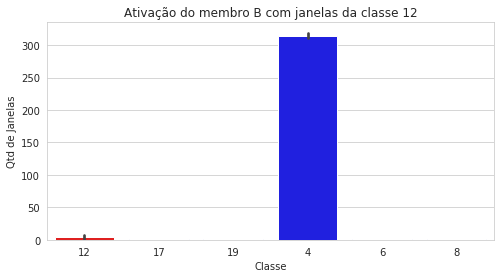

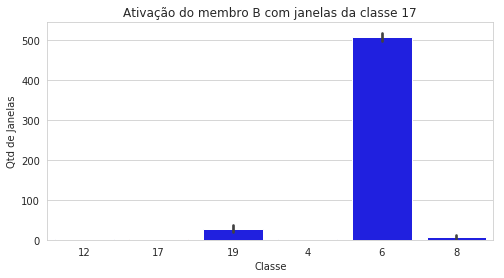

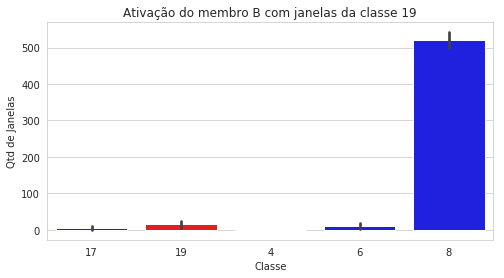

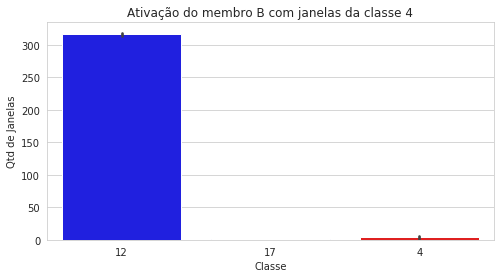

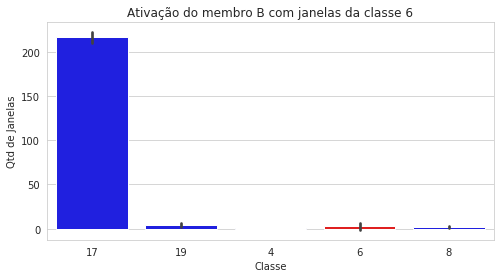

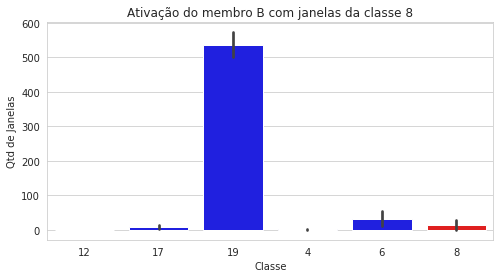

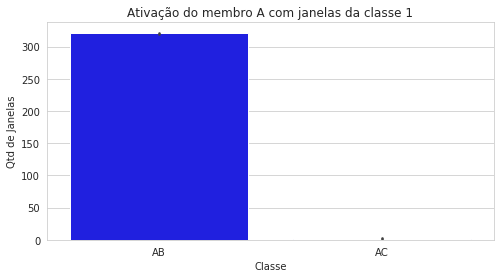

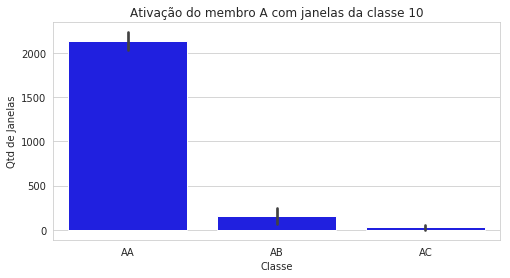

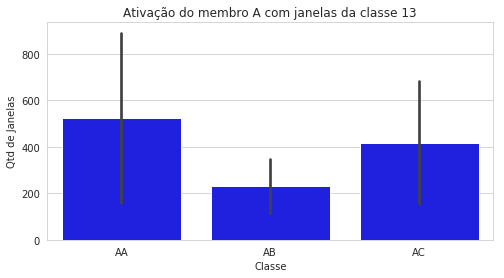

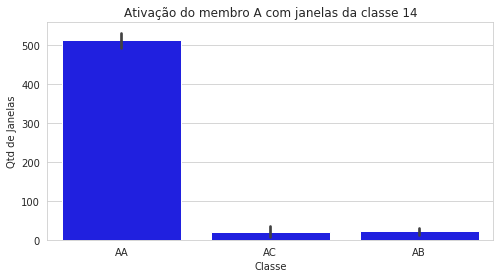

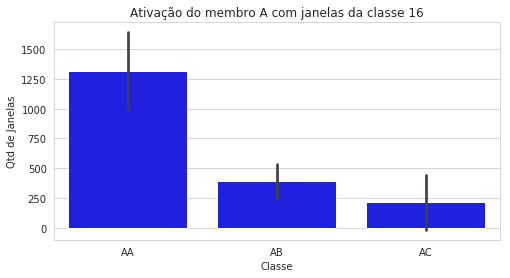

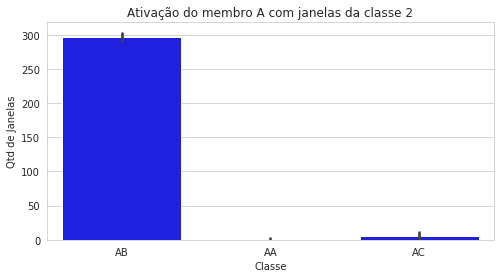

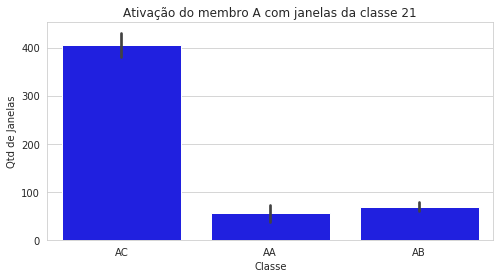

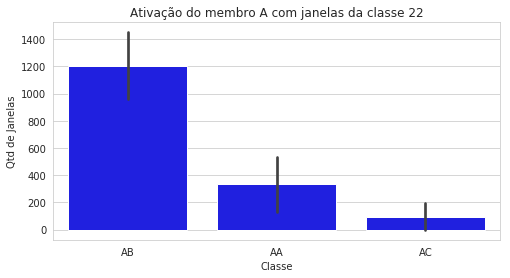

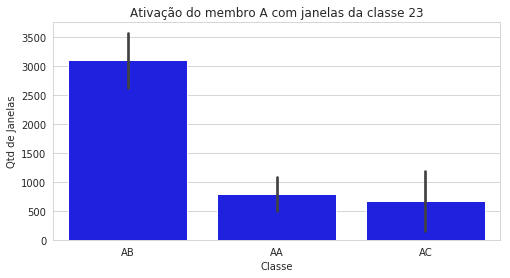

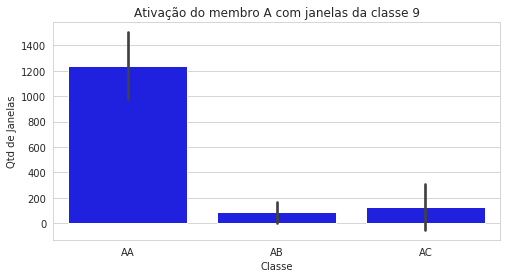

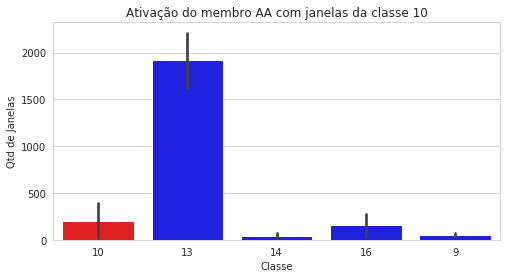

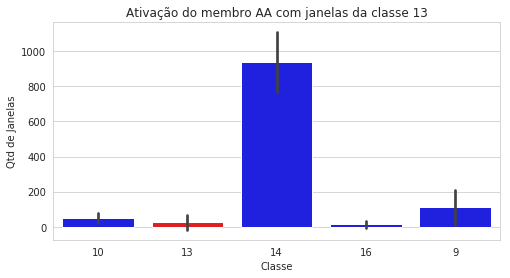

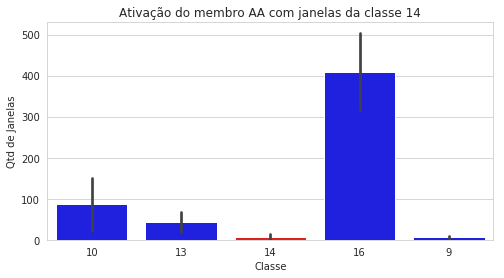

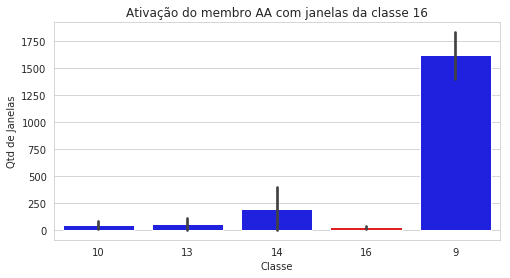

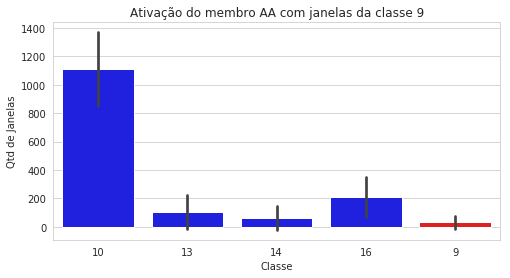

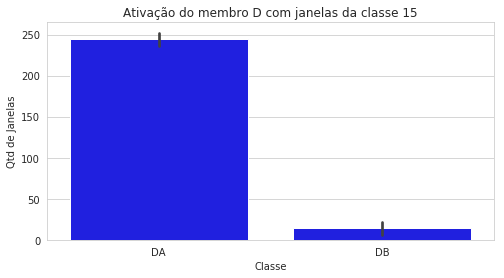

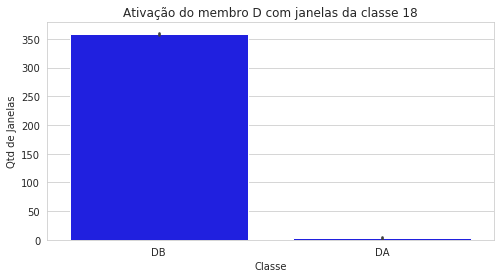

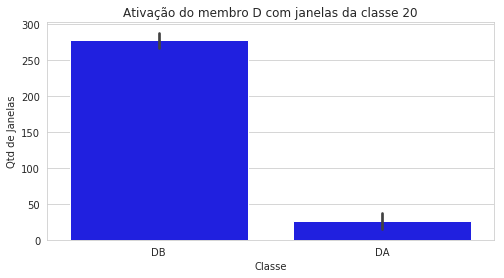

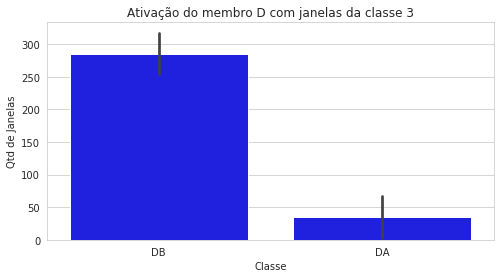

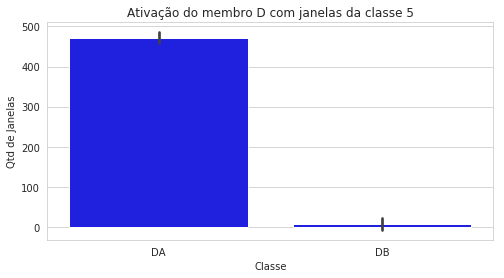

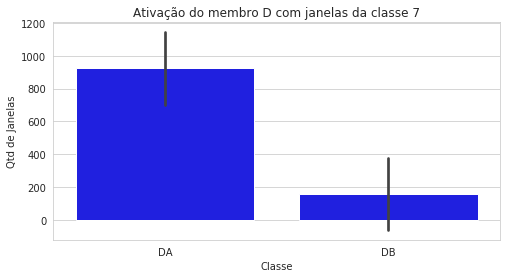

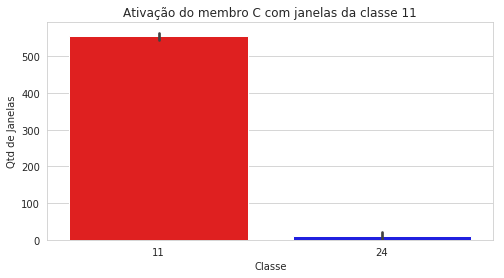

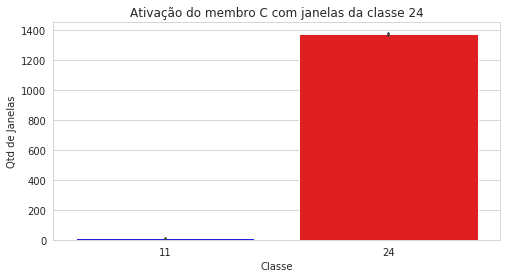

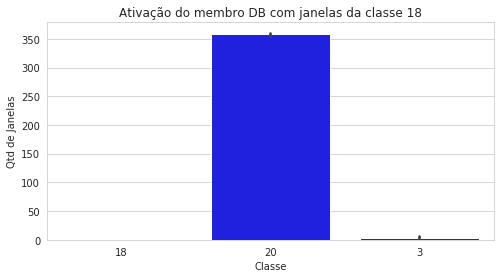

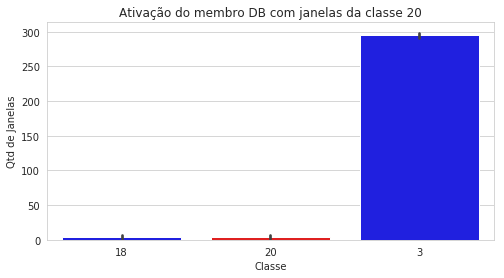

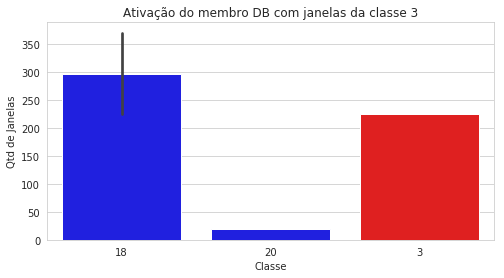

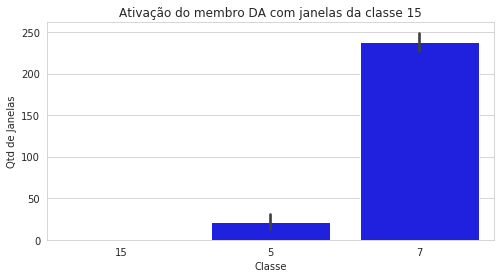

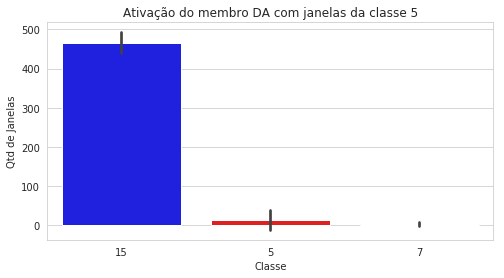

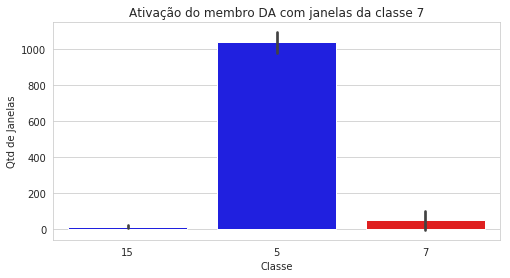

In [10]:
sns.set_style("whitegrid")

data=df_preCLass.reset_index()

if database=='31classes':
    for member in classes.keys()[:-1]:
        member = member.split('_')[-1]
        list_of_ref =  data[data['Membro']==member]['refClasse'].unique()
        for iclass in list_of_ref:
            idata = data[(data['Membro']==member)&(data['refClasse']==iclass)]

            #all_classes = sorted(idata.classe.unique())

            fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
            fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.8)
            ax = axes

            colors = []
            iabove=[]
            isame=[]

            for i in np.unique(idata['classe']):
                color='blue'

                if i in iabove:
                    color = 'yellow'

                if i in isame:
                    color = 'orange'

                if i==(iclass):
                    color = 'red'

                colors.append(color)

            g = sns.barplot(y='Qtd de Janelas',x='classe',ax=ax,data=idata,ci='sd',palette=sns.color_palette(colors))
            g.set_xlabel('Classe')
            g.set_title(u'Ativação do membro {} com janelas da classe {}'.format(member.split("_")[-1],iclass))
            #if save_flag: savefig(g, file_hier +  '/Histograma_ativacao_classe_{0}.png'.format(iclass))

if database=='24classes':
    for member in classes.keys()[:-1]:
        member = member.split('_')[-1]
        list_of_ref =  data[data['Membro']==member]['refClasse'].unique()
        for iclass in list_of_ref:
            idata = data[(data['Membro']==member)&(data['refClasse']==iclass)]

            #all_classes = sorted(idata.classe.unique())

            fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
            fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.8)
            ax = axes

            colors = []
            iabove=[]
            isame=[]

            for i in np.unique(idata['classe']):
                color='blue'

                if i in iabove:
                    color = 'yellow'

                if i in isame:
                    color = 'orange'

                if i==(iclass):
                    color = 'red'

                colors.append(color)

            g = sns.barplot(y='Qtd de Janelas',x='classe',ax=ax,data=idata,ci='sd',palette=sns.color_palette(colors))
            g.set_xlabel('Classe')
            g.set_title(u'Ativação do membro {} com janelas da classe {}'.format(member.split("_")[-1],iclass))
            #if save_flag: savefig(g, file_hier +  '/Histograma_ativacao_classe_{0}.png'.format(iclass))

In [24]:
save_flag = True

def colors_plot(x,list_classes,color_neg='b',color_pos='red'):
    x_classes = map(lambda x:x+1,x)
    
    color_classes = {}
    for ind in x_classes:
        color_classes[ind] = 'b'
        if ind in list_classes:
            color_classes[ind] = color_pos

    list_of_colors=[]
    for ind in x_classes:
        list_of_colors.append(color_classes[ind])
    return list_of_colors
            

if database=='24classes':
    for father_class in ['class_AA','class_AB','class_DA','class_DB','class_B','class_C']:
        for nclass in range(len(classes[father_class])):
            id = table_master[(table_master[father_class]==nclass)&(table_master['fold_0{0}'.format(best_fold)]==1)].index.values
            df_pred_member = table_master.loc[id,:]['{}_pred'.format(father_class)]
            n_windows = df_pred_member.shape[0]
            df_pred_tmp = df_pred_member


            x = df_pred_member.value_counts().index.values
            y = df_pred_member.value_counts().values

            list_of_colors = colors_plot(map(lambda x:x-1,[classes[father_class][i][0] for i in x]),classes[father_class][nclass])

            pldf = pd.DataFrame({'freq':y,'class':map(lambda x:x+1,x)}).plot(x='class',y='freq',kind='bar',legend=False,color=list_of_colors)

            pldf.set_xticklabels(labels=[classes[father_class][i][0] for i in x])

            pldf.set_xlabel('classes\n Total: {0}'.format(n_windows))
            pldf.set_ylabel('Qtd de Janelas')

            pldf.set_title(u'predição do membro {} com \n janelas da class {} (fold {})'.format(father_class.split('_')[-1],classes[father_class][nclass][0],best_fold+1))
            fig = pldf.get_figure()
            if save_flag:savefig(plt=fig,filename=file_hier+'/fold0{0}'.format(best_fold)+'/{0}'.format(father_class)+'/activation_with_class{0}.png'.format(classes[father_class][nclass][0]))

    lv3_classes = [['A','B','C','D'],['AA','AB','AC'],['DA','DB']]
    n_lv3 = [len(i) for i in lv3_classes]
    lv1_class = ['class_S','class_A','class_D']

    for father_class,child_class,n_class in zip(lv1_class,lv3_classes,n_lv3):
        for iclass in range(n_class):
            id = table_master[(table_master[father_class]==iclass)&(table_master['fold_0{0}'.format(best_fold)]==1)].index.values
            df_pred_member = table_master.loc[id,:]['{}_pred'.format(father_class)]
            n_windows = df_pred_member.shape[0]
            df_pred_tmp = df_pred_member

            x = df_pred_member.value_counts().index.values
            y = df_pred_member.value_counts().values

            list_of_colors = len(child_class)*['b']
            count=0
            for i in x:
                if i==iclass:
                    list_of_colors[count]='orange'
                count=count+1

            #list_of_colors = colors_plot(map(lambda x:x-1,[child_class[i] for i in x]),classes[father_class][nclass])

            pldf = pd.DataFrame({'freq':y,'class':x}).plot(x='class',y='freq',kind='bar',legend=False,color=list_of_colors)

            pldf.set_xticklabels(labels=[child_class[i] for i in x])

            pldf.set_xlabel('membros \n Total: {0}'.format(n_windows))
            pldf.set_ylabel('Qtd de Janelas')

            pldf.set_title(u'predição do membro {} com \n janelas do membro {} (fold {})'.format(father_class.split('_')[-1],child_class[iclass],best_fold+1))

            fig = pldf.get_figure()
            if save_flag:savefig(plt=fig,filename=file_hier+'/fold0{0}'.format(best_fold)+'/{0}'.format(father_class)+'/activation_with_member{0}.png'.format(child_class[iclass]))

if database=='31classes':
    for father_class in ['class_B3','class_B5','class_B8']:
        for nclass in range(len(classes[father_class])):
            
            table_master = pd.read_csv(file_hier+'/fold0{0}'.format(best_fold)+'/master_table.csv')
            
            id = table_master[(table_master[father_class]==nclass)&(table_master['fold_0{0}'.format(best_fold)]==1)].index.values
            df_pred_member = table_master.loc[id,:]['{}_pred'.format(father_class)]
            n_windows = df_pred_member.shape[0]
            df_pred_tmp = df_pred_member


            x = df_pred_member.value_counts().index.values
            y = df_pred_member.value_counts().values

            list_of_colors = colors_plot(map(lambda x:x-1,[classes[father_class][i][0] for i in x]),classes[father_class][nclass])

            pldf = pd.DataFrame({'freq':y,'class':map(lambda x:x+1,x)}).plot(x='class',y='freq',kind='bar',legend=False,color=list_of_colors)

            pldf.set_xticklabels(labels=[classes[father_class][i][0] for i in x])

            pldf.set_xlabel('classes\n Total: {0}'.format(n_windows))
            pldf.set_ylabel('Qtd de Janelas')

            pldf.set_title(u'predição do membro {} com \n janelas da class {} (fold {})'.format(father_class.split('_')[-1],classes[father_class][nclass][0],best_fold+1))
            fig = pldf.get_figure()
            if save_flag:savefig(plt=fig,filename=file_hier+'/fold0{0}'.format(best_fold)+'/{0}'.format(father_class)+'/activation_with_class{0}.png'.format(classes[father_class][nclass][0]))
            if save_flag: savefig(plt=fig,filename=tese_goltz+'/fold0{0}_{1}_fatherClass_activation_with_class{2}.png'.format(best_fold,father_class,classes[father_class][nclass][0]))
                
    lv3_classes = [['A','B'],[1,2,3,4],["B{}".format(i) for i in range(1,9)]]
    n_lv3 = [len(i) for i in lv3_classes]
    lv1_class = ['class_S','class_A','class_B']

    for father_class,child_class,n_class in zip(lv1_class,lv3_classes,n_lv3):
        for iclass in range(n_class):
            id = table_master[(table_master[father_class]==iclass)&(table_master['fold_0{0}'.format(best_fold)]==1)].index.values
            df_pred_member = table_master.loc[id,:]['{}_pred'.format(father_class)]
            n_windows = df_pred_member.shape[0]
            df_pred_tmp = df_pred_member

            x = df_pred_member.value_counts().index.values
            y = df_pred_member.value_counts().values

            list_of_colors = len(child_class)*['b']
            count=0
            for i in x:
                if i==iclass:
                    list_of_colors[count]='red'
                count=count+1

            #list_of_colors = colors_plot(map(lambda x:x-1,[child_class[i] for i in x]),classes[father_class][nclass])

            pldf = pd.DataFrame({'freq':y,'class':x}).plot(x='class',y='freq',kind='bar',legend=False,color=list_of_colors)

            pldf.set_xticklabels(labels=[child_class[i] for i in x])

            pldf.set_xlabel('membros \n Total: {0}'.format(n_windows))
            pldf.set_ylabel('Qtd de Janelas')

            pldf.set_title(u'predição do membro {} com \n janelas do membro {} (fold {})'.format(father_class.split('_')[-1],child_class[iclass],best_fold+1))

            fig = pldf.get_figure()
            if save_flag:savefig(plt=fig,filename=file_hier+'/fold0{0}'.format(best_fold)+'/{0}'.format(father_class)+'/activation_with_member{0}.png'.format(child_class[iclass]))
            if save_flag: savefig(plt=fig,filename=tese_goltz+'/fold0{0}_{1}_fatherClass_activation_with_member{2}.png'.format(best_fold,father_class,child_class[iclass]))

TypeError: list indices must be integers, not str

In [26]:
table_master = pd.read_csv(file_hier+'/fold0{0}'.format(0)+'/master_table.csv')
print table_master['class_S'].value_counts().to_dict()

{0: 147227, 1: 25446, 2: 19449, 3: 28041}

In [28]:
print 'class_A'
print table_master['class_A'].value_counts().to_dict()

class_A
{0: 73875, 1: 68060, 2: 5292, -1: 72936}


In [32]:
for iclass in class_name:
    print '{0} : {1}'.format(iclass,table_master[iclass].value_counts().to_dict())

class_B : {0: 3203, 1: 2232, 2: 5898, 3: 3192, 4: 5428, 5: 5493, -1: 194717}
class_S : {0: 147227, 1: 25446, 2: 19449, 3: 28041}
class_A : {0: 73875, 1: 68060, 2: 5292, -1: 72936}
class_AA : {0: 14562, 1: 23224, 2: 11314, 3: 5542, 4: 19233, -1: 146288}
class_D : {0: 18184, 1: 9857, -1: 192122}
class_C : {0: 5633, 1: 13816, -1: 200714}
class_DB : {0: 3212, 1: 3614, 2: 3031, -1: 210306}
class_DA : {0: 4781, 1: 10821, 2: 2582, -1: 201979}
class_AB : {0: 45589, 1: 3209, 2: 3037, 3: 16225, -1: 152103}
